## Task 1


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import json
import warnings
warnings.filterwarnings("ignore")

# Data Loading

In [ ]:
matches = pd.read_csv("matches.csv")
deliveries = pd.read_csv("deliveries.csv")

In [ ]:
with open('Mapping_Cleaning\\team_name_correction.json', 'r') as f:
    team_name_correction = json.load(f)

with open('Mapping_Cleaning\\stadium_name_correction.json', 'r') as f:
    stadium_name_correction = json.load(f)

matches=matches.replace(team_name_correction)
matches=matches.replace(stadium_name_correction)


deliveries=deliveries.replace(team_name_correction)
deliveries=deliveries.replace(stadium_name_correction)

# Data Cleaning and Standardization

In [ ]:
matches.fillna("NA", inplace=True)
deliveries.fillna("NA", inplace=True)

In [ ]:
def standardize_team_name(team):
    team_dict = {
        "Delhi Daredevils": "Delhi Capitals",
        "Deccan Chargers": "Sunrisers Hyderabad",
        "Royal Challengers Bangalore": "Royal Challengers Bengaluru",
        "Rising Pune Supergiant": "Rising Pune Supergiants",
        "Kings XI Punjab": "Punjab Kings"
    }
    return team_dict.get(team, team)

matches['team1'] = matches['team1'].apply(standardize_team_name)
matches['team2'] = matches['team2'].apply(standardize_team_name)
matches['winner'] = matches['winner'].apply(standardize_team_name)
deliveries['batting_team'] = deliveries['batting_team'].apply(standardize_team_name)
deliveries['bowling_team'] = deliveries['bowling_team'].apply(standardize_team_name)



In [ ]:
matches['team1'].unique()

array(['Royal Challengers Bengaluru', 'Punjab Kings', 'Delhi Capitals',
       'Mumbai Indians', 'Kolkata Knight Riders', 'Rajasthan Royals',
       'Sunrisers Hyderabad', 'Chennai Super Kings',
       'Kochi Tuskers Kerala', 'Rising Pune Supergiants',
       'Gujarat Titans', 'Lucknow Super Giants'], dtype=object)

In [ ]:
def standardize_season(season):
    season_dict = {
        "2007/08": "2008",
        "2009/10": "2010",
        "2020/21": "2020"
    }
    return season_dict.get(season, season)

matches['season'] = matches['season'].apply(standardize_season)

In [ ]:
matches['target_overs'] = pd.to_numeric(matches['target_overs'], errors='coerce')
matches['target_runs'] = pd.to_numeric(matches['target_runs'], errors='coerce')
matches['result_margin'] = pd.to_numeric(matches['result_margin'], errors='coerce')

# Team Analysis

## Winning Percentage of Teams

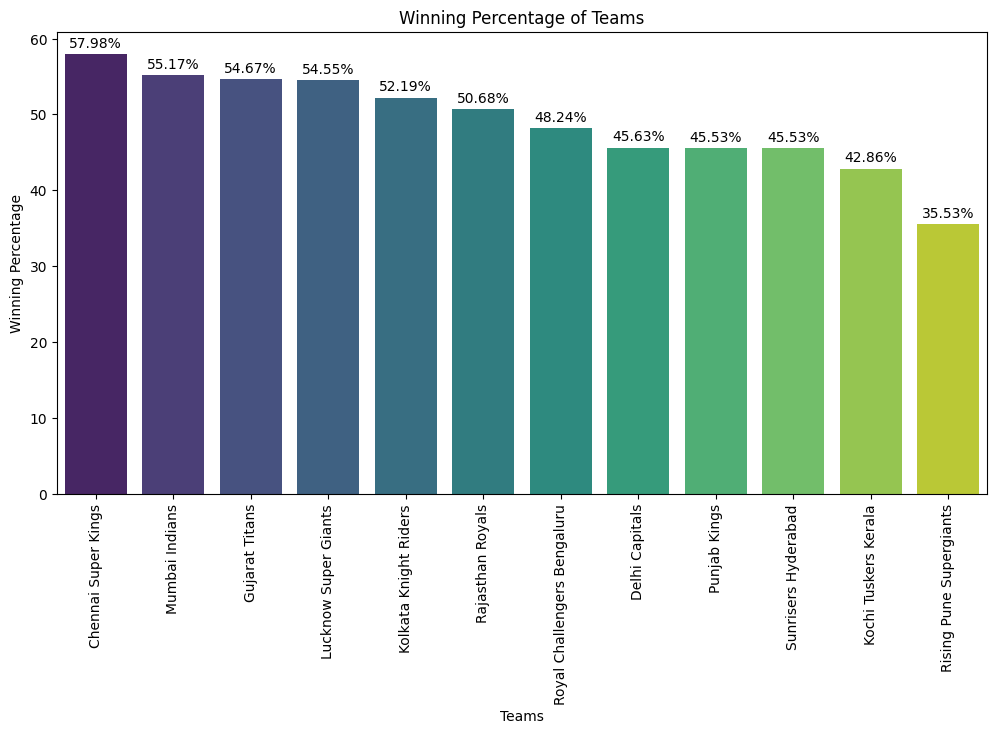

In [ ]:
matches_played = matches['team1'].value_counts() + matches['team2'].value_counts()
matches_won = matches['winner'].value_counts()
team_to_remove = 'NA'
matches_won = matches_won[matches_won.index != team_to_remove]
winning_percentage = (matches_won / matches_played * 100).sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=winning_percentage.index, y=winning_percentage.values, palette='viridis')
plt.xticks(rotation=90)
plt.xlabel("Teams")
plt.ylabel("Winning Percentage")
plt.title("Winning Percentage of Teams")

for i, v in enumerate(winning_percentage.values):
    plt.text(i, v + 0.5, f"{v:.2f}%", ha='center', va='bottom', fontsize=10)

plt.show()


## Average Run Rate of Each Team and Average Economy Rate of Each Team

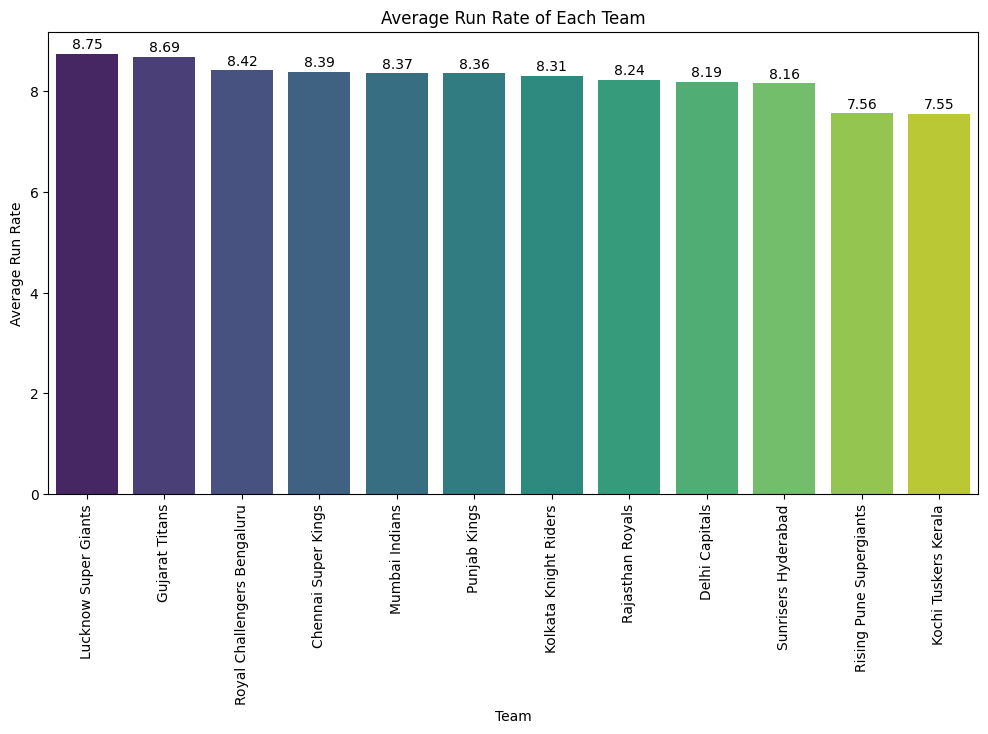

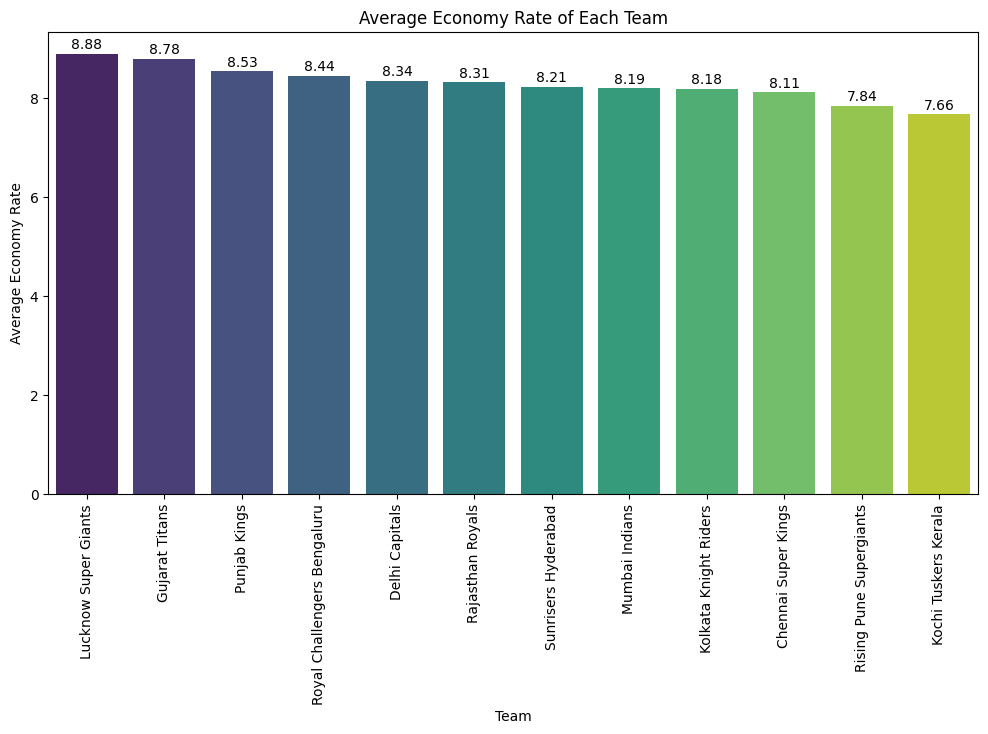

In [ ]:
valid_deliveries = deliveries[~deliveries['extras_type'].isin(['wides', 'noballs'])]

team_runs_scored = deliveries.groupby('batting_team')['total_runs'].sum()
team_overs_faced = valid_deliveries.groupby('batting_team').size() / 6

team_run_rate = (team_runs_scored / team_overs_faced).reset_index(name='Run Rate')
team_run_rate = team_run_rate.sort_values(by='Run Rate', ascending=False)

team_runs_conceded = deliveries.groupby('bowling_team')['total_runs'].sum()
team_overs_bowled = valid_deliveries.groupby('bowling_team').size() / 6

team_economy_rate = (team_runs_conceded / team_overs_bowled).reset_index(name='Economy Rate')
team_economy_rate = team_economy_rate.sort_values(by='Economy Rate', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='batting_team', y='Run Rate', data=team_run_rate, palette='viridis')
plt.xticks(rotation=90)
plt.xlabel("Team")
plt.ylabel("Average Run Rate")
plt.title("Average Run Rate of Each Team")
for i, v in enumerate(team_run_rate['Run Rate']):
    plt.text(i, v + 0.1, f"{v:.2f}", ha='center', fontsize=10)
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x='bowling_team', y='Economy Rate', data=team_economy_rate, palette='viridis')
plt.xticks(rotation=90)
plt.xlabel("Team")
plt.ylabel("Average Economy Rate")
plt.title("Average Economy Rate of Each Team")
for i, v in enumerate(team_economy_rate['Economy Rate']):
    plt.text(i, v + 0.1, f"{v:.2f}", ha='center', fontsize=10)
plt.show()


## Highest and Lowest scores by Teams

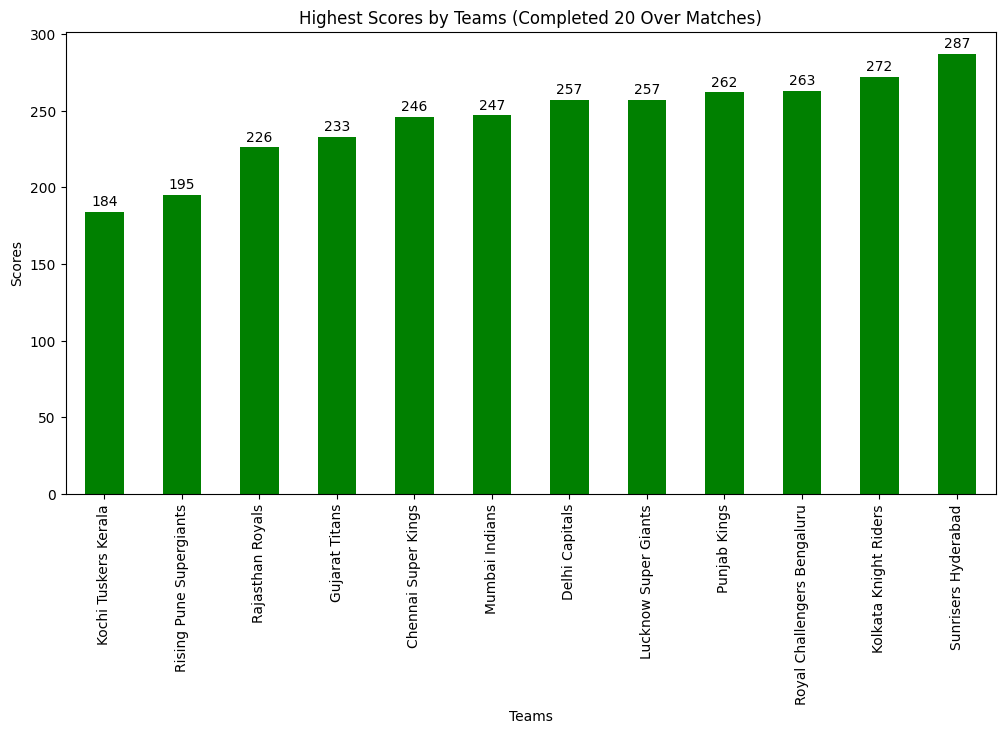

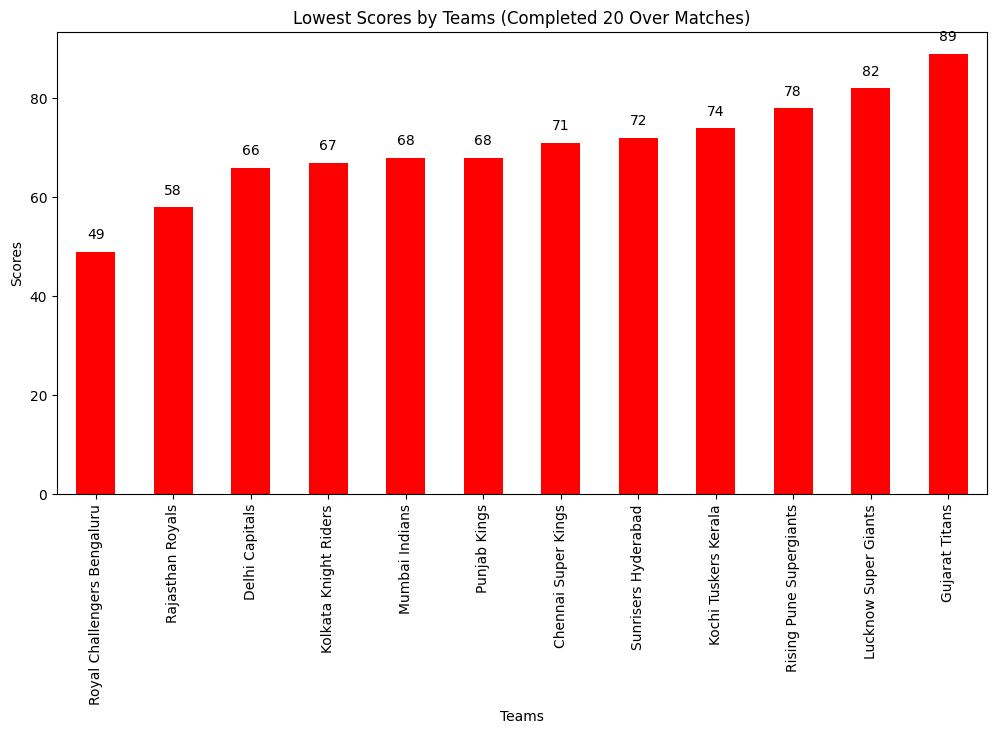

In [ ]:
match_results = matches.set_index('id')['result']
target_overs = matches.set_index('id')['target_overs']

team_scores = deliveries.groupby(['match_id', 'batting_team'])['total_runs'].sum().reset_index()

team_scores['result'] = team_scores['match_id'].map(match_results)
team_scores['target_overs'] = team_scores['match_id'].map(target_overs)

valid_team_scores = team_scores[(team_scores['result'] != 'no result') & (team_scores['target_overs'] == 20)]

highest_scores = valid_team_scores.groupby('batting_team')['total_runs'].max()
lowest_scores = valid_team_scores.groupby('batting_team')['total_runs'].min()

plt.figure(figsize=(12, 6))
bars_high = highest_scores.sort_values().plot(kind='bar', color='green')
plt.xlabel("Teams")
plt.ylabel("Scores")
plt.title("Highest Scores by Teams (Completed 20 Over Matches)")
plt.xticks(rotation=90)

for bar in bars_high.patches:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 2,
             f'{int(bar.get_height())}', ha='center', va='bottom', fontsize=10)

plt.show()

plt.figure(figsize=(12, 6))
bars_low = lowest_scores.sort_values().plot(kind='bar', color='red')
plt.xlabel("Teams")
plt.ylabel("Scores")
plt.title("Lowest Scores by Teams (Completed 20 Over Matches)")
plt.xticks(rotation=90)

for bar in bars_low.patches:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 2,
             f'{int(bar.get_height())}', ha='center', va='bottom', fontsize=10)

plt.show()


## Total 4s and 6s by Teams

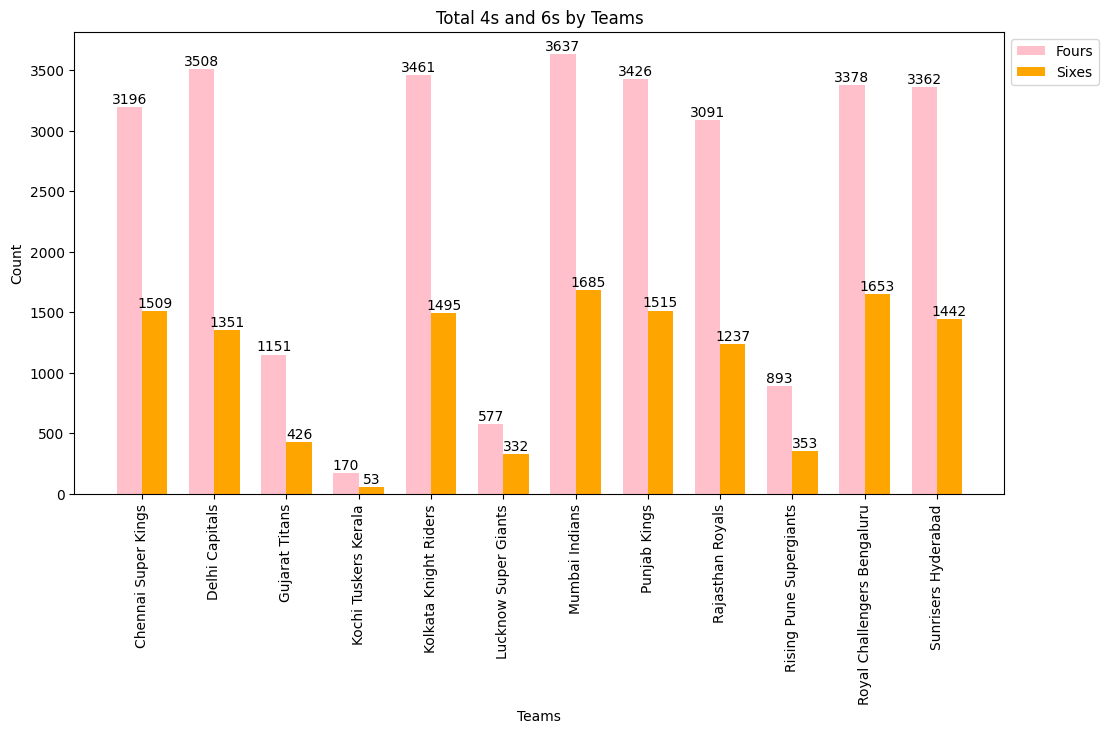

In [ ]:
fours = deliveries[(deliveries['batsman_runs'] == 4)].groupby('batting_team').size()
sixes = deliveries[(deliveries['batsman_runs'] == 6)].groupby('batting_team').size()

bar_width = 0.35
teams = fours.index
x = np.arange(len(teams))

plt.figure(figsize=(12, 6))
bars_fours = plt.bar(x - bar_width / 2, fours.values, width=bar_width, color='pink', label='Fours')
bars_sixes = plt.bar(x + bar_width / 2, sixes.values, width=bar_width, color='orange', label='Sixes')

for bar in bars_fours:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5,
             f'{int(bar.get_height())}', ha='center', va='bottom', fontsize=10)

for bar in bars_sixes:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5,
             f'{int(bar.get_height())}', ha='center', va='bottom', fontsize=10)

plt.xlabel("Teams")
plt.ylabel("Count")
plt.title("Total 4s and 6s by Teams")
plt.xticks(x, teams, rotation=90)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

## Powerplay vs Death Overs Scores

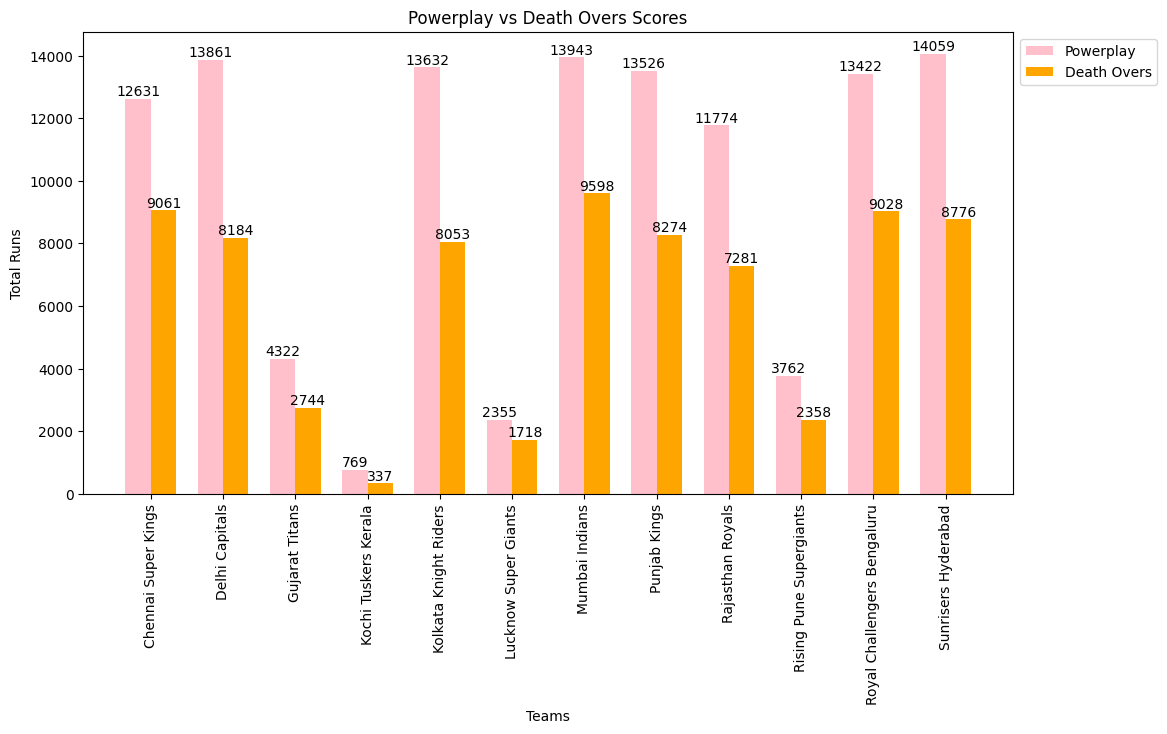

In [ ]:
powerplay_scores = deliveries[(deliveries['over'] <= 6)].groupby('batting_team')['total_runs'].sum()
death_overs_scores = deliveries[(deliveries['over'] >= 16)].groupby('batting_team')['total_runs'].sum()

bar_width = 0.35
teams = powerplay_scores.index
x = np.arange(len(teams))

plt.figure(figsize=(12, 6))
bars_powerplay = plt.bar(x - bar_width / 2, powerplay_scores.values, width=bar_width, color='pink', label='Powerplay')
bars_death = plt.bar(x + bar_width / 2, death_overs_scores.values, width=bar_width, color='orange', label='Death Overs')

for bar in bars_powerplay:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5,
             f'{int(bar.get_height())}', ha='center', va='bottom', fontsize=10)

for bar in bars_death:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5,
             f'{int(bar.get_height())}', ha='center', va='bottom', fontsize=10)

plt.xlabel("Teams")
plt.ylabel("Total Runs")
plt.title("Powerplay vs Death Overs Scores")
plt.xticks(x, teams, rotation=90)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [ ]:
deliveries["extras_type"].unique()

array(['legbyes', 'NA', 'wides', 'byes', 'noballs', 'penalty'],
      dtype=object)

## Average Runs per Over of Teams

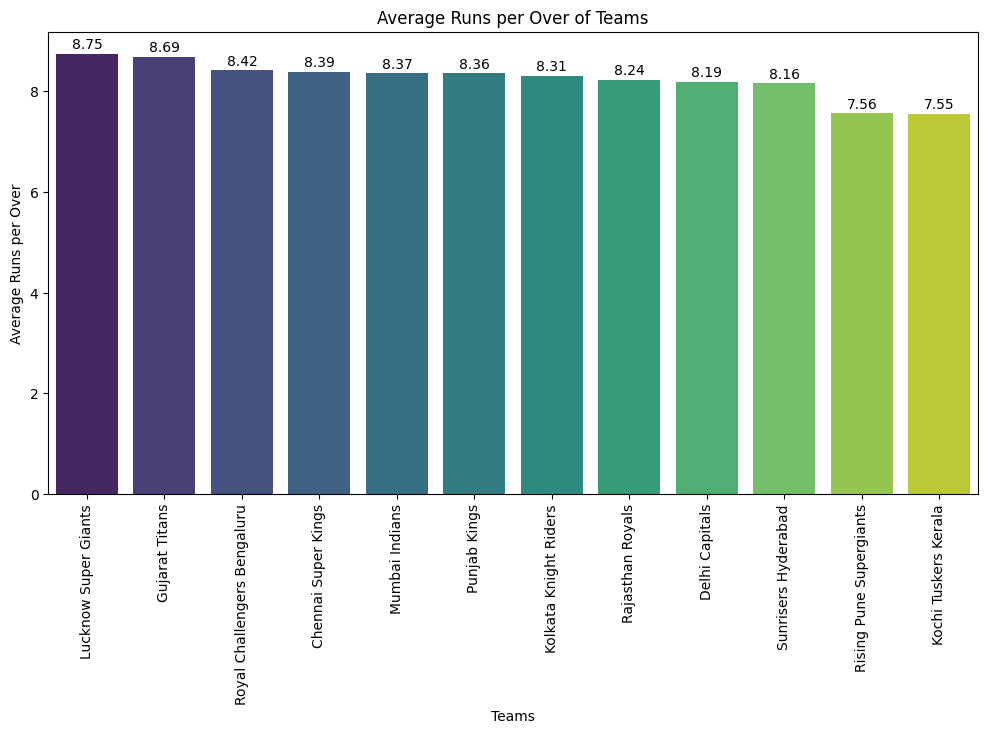

In [ ]:
total_runs_scored = deliveries.groupby('batting_team')['total_runs'].sum()
valid_deliveries = deliveries[(deliveries['extras_type'] != 'wides') & (deliveries['extras_type'] != 'noballs')]
total_overs_faced = valid_deliveries.groupby('batting_team').size() / 6

avg_run_rate = total_runs_scored / total_overs_faced

avg_run_rate = avg_run_rate.sort_values(ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x=avg_run_rate.index, y=avg_run_rate.values, palette='viridis')
plt.xticks(rotation=90)
plt.xlabel("Teams")
plt.ylabel("Average Runs per Over")
plt.title("Average Runs per Over of Teams")
for i, v in enumerate(avg_run_rate.values):
    plt.text(i, v + 0.1, f"{v:.2f}", ha='center', fontsize=10)
plt.show()

## Powerplay Performance by Teams

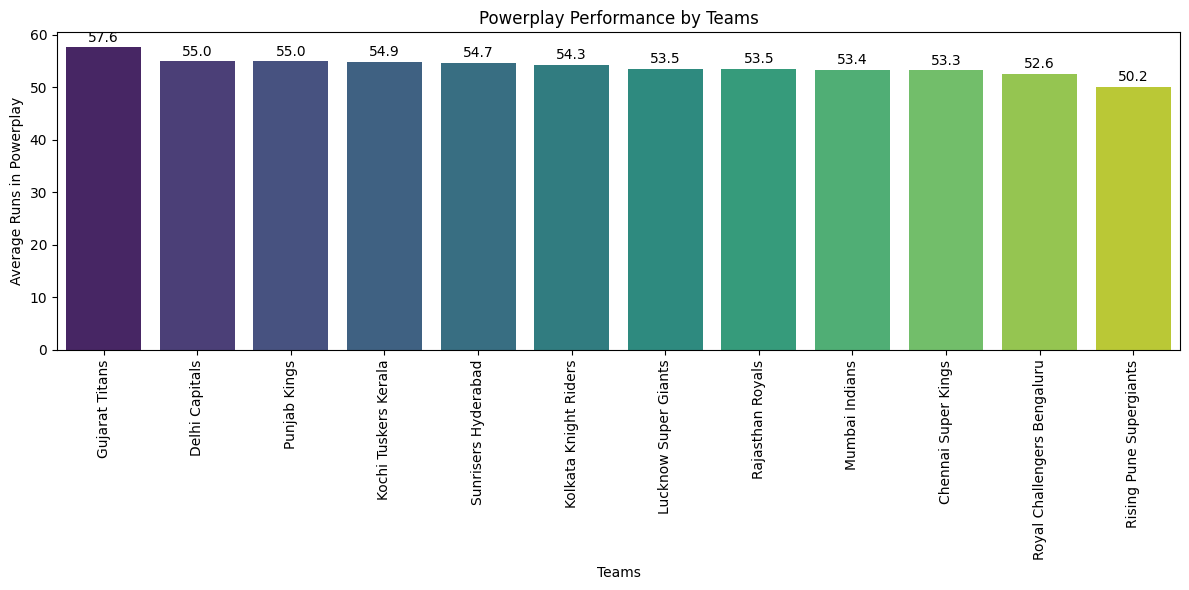

In [ ]:
powerplay_runs = deliveries[deliveries['over'] <= 6].groupby(['match_id', 'batting_team'])['total_runs'].sum().reset_index()
powerplay_matches = powerplay_runs.groupby('batting_team')['match_id'].nunique()
powerplay_avg = powerplay_runs.groupby('batting_team')['total_runs'].sum() / powerplay_matches

powerplay_avg = powerplay_avg.sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=powerplay_avg.index, y=powerplay_avg.values, palette='viridis')

plt.xticks(rotation=90)
plt.xlabel("Teams")
plt.ylabel("Average Runs in Powerplay")
plt.title("Powerplay Performance by Teams")

for i, v in enumerate(powerplay_avg.values):
    plt.text(i, v + 0.5, f"{v:.1f}", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Player Analysis

## Top 20 Run Scorers

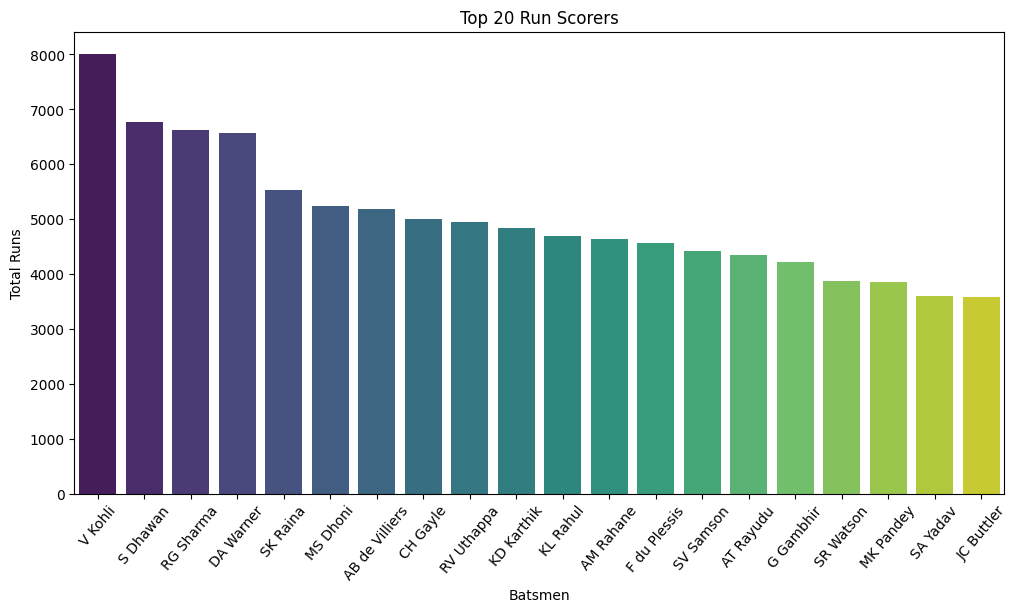

In [ ]:
top_run_scorers = deliveries.groupby('batter')['batsman_runs'].sum().nlargest(20)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_run_scorers.index, y=top_run_scorers.values, palette='viridis')
plt.xticks(rotation=50)
plt.xlabel('Batsmen')
plt.ylabel('Total Runs')
plt.title('Top 20 Run Scorers')
plt.show()

## Batting Average vs Strike Rate for Top 20 Run Scorers

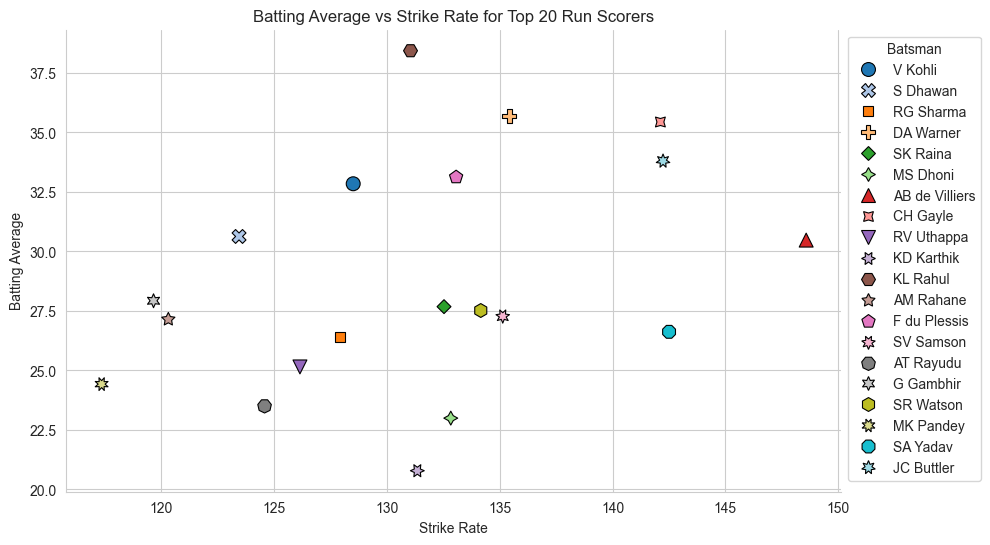

In [ ]:
batting_stats = deliveries.groupby('batter').agg(
    Runs=('batsman_runs', 'sum'),
    Balls_Faced=('ball', 'count'),
    Matches=('match_id', 'nunique')
)

batting_stats = batting_stats.loc[top_run_scorers.index]


batting_stats['Strike Rate'] = (batting_stats['Runs'] / batting_stats['Balls_Faced']) * 100
batting_stats['Batting Average'] = batting_stats['Runs'] / batting_stats['Matches']


plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

scatter = sns.scatterplot(
    x=batting_stats['Strike Rate'],
    y=batting_stats['Batting Average'],
    hue=batting_stats.index,
    style=batting_stats.index,
    palette='tab20',
    s=100,
    edgecolor="black"
)

plt.xlabel('Strike Rate')
plt.ylabel('Batting Average')
plt.title('Batting Average vs Strike Rate for Top 20 Run Scorers')

plt.legend(title='Batsman', bbox_to_anchor=(1, 1), fontsize=10)
sns.despine()

plt.show()


## Top 10 Batsmen by Strike Rate and Batting Average (Min. 50 Matches)

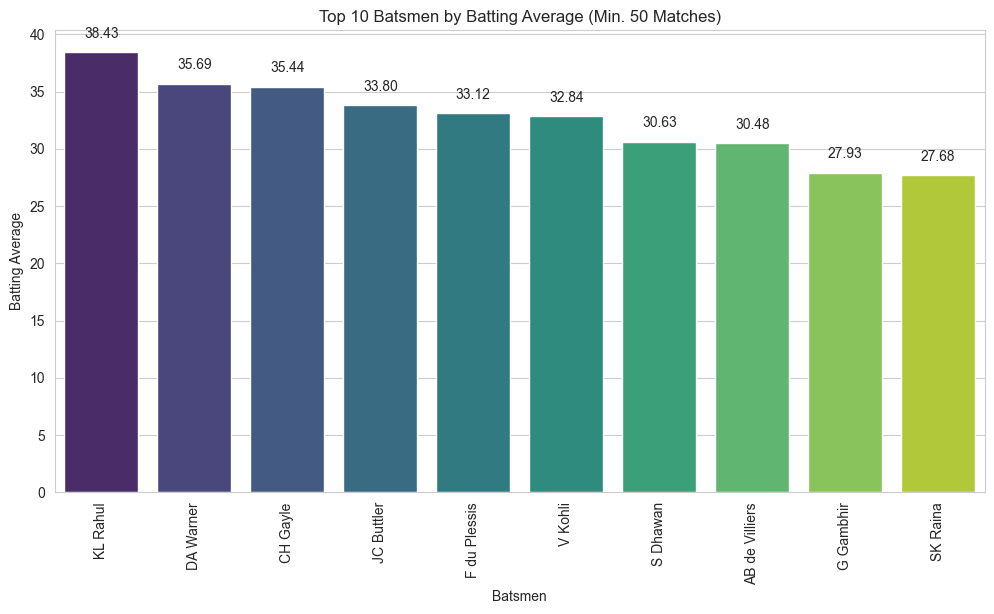

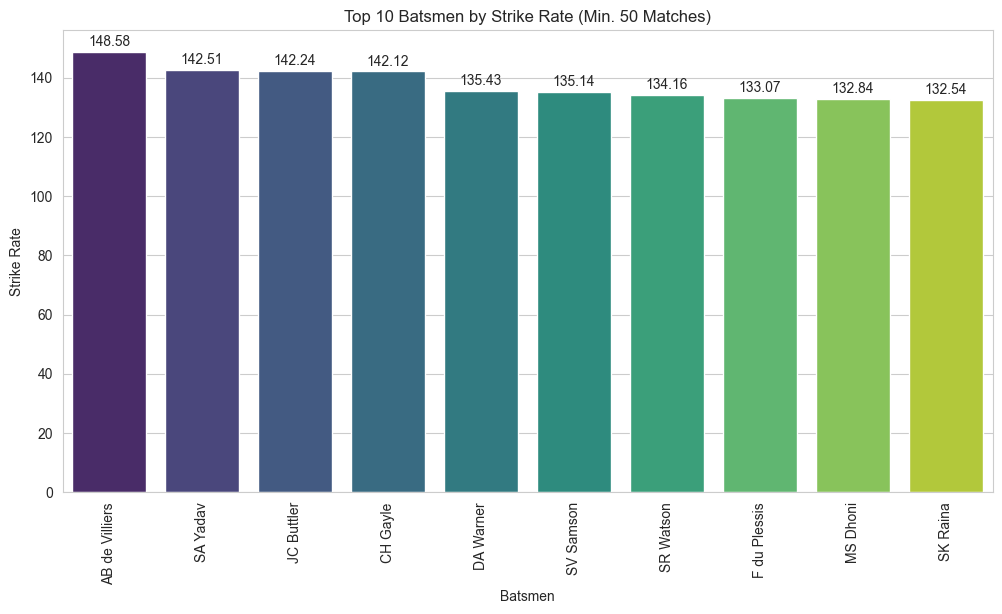

In [ ]:
batting_stats['Matches'] = deliveries.groupby('batter')['match_id'].nunique()
filtered_batsmen = batting_stats[batting_stats['Matches'] > 50]
filtered_batsmen['Batting Average'] = filtered_batsmen['Runs'] / filtered_batsmen['Matches']


top_batting_average = filtered_batsmen.nlargest(10, 'Batting Average')


top_strike_rate = filtered_batsmen.nlargest(10, 'Strike Rate')



plt.figure(figsize=(12, 6))
sns.barplot(x=top_batting_average.index, y=top_batting_average['Batting Average'], palette='viridis')
plt.xticks(rotation=90)
plt.xlabel('Batsmen')
plt.ylabel('Batting Average')
plt.title('Top 10 Batsmen by Batting Average (Min. 50 Matches)')

for i, v in enumerate(top_batting_average['Batting Average'].values):
    plt.text(i, v + 1, f"{v:.2f}", ha='center', va='bottom', fontsize=10)

plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x=top_strike_rate.index, y=top_strike_rate['Strike Rate'], palette='viridis')
plt.xticks(rotation=90)
plt.xlabel('Batsmen')
plt.ylabel('Strike Rate')
plt.title('Top 10 Batsmen by Strike Rate (Min. 50 Matches)')

for i, v in enumerate(top_strike_rate['Strike Rate'].values):
    plt.text(i, v + 1, f"{v:.2f}", ha='center', va='bottom', fontsize=10)

plt.show()


## Top 10 Wicket-Takers

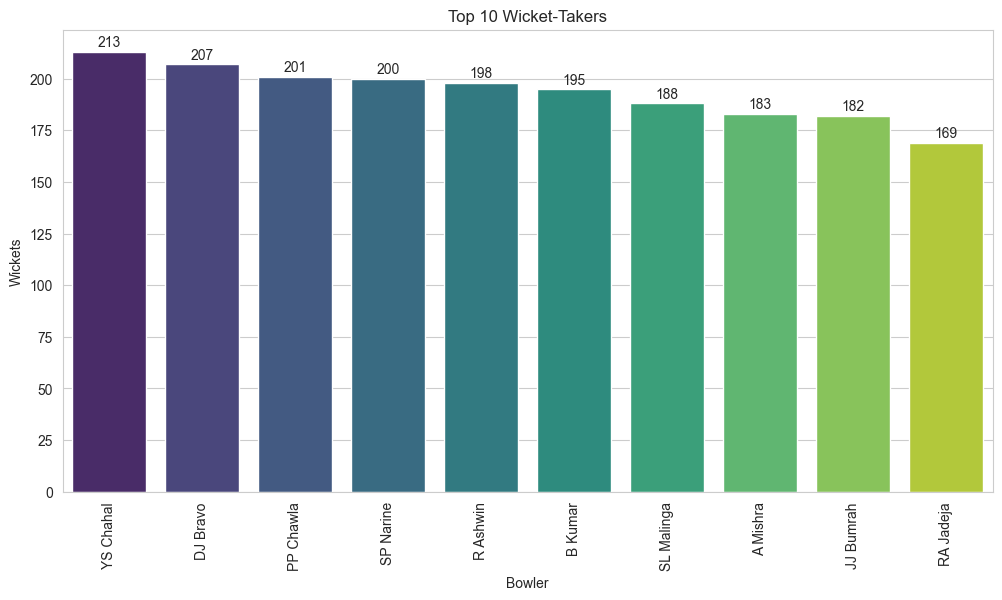

In [ ]:
wicket_stats = deliveries[deliveries["is_wicket"] == 1].groupby("bowler").agg({"is_wicket": "sum"}).rename(columns={"is_wicket": "wickets"})
top_wicket_takers = wicket_stats.nlargest(10, "wickets")


plt.figure(figsize=(12, 6))
sns.barplot(x=top_wicket_takers.index, y=top_wicket_takers["wickets"], palette="viridis")
plt.xticks(rotation=90)
plt.title("Top 10 Wicket-Takers")
plt.xlabel("Bowler")
plt.ylabel("Wickets")

for i, v in enumerate(top_wicket_takers["wickets"].values):
    plt.text(i, v + 1, f"{v}", ha='center', va='bottom', fontsize=10)

plt.show()


## Top 10 Highest Individual Scores

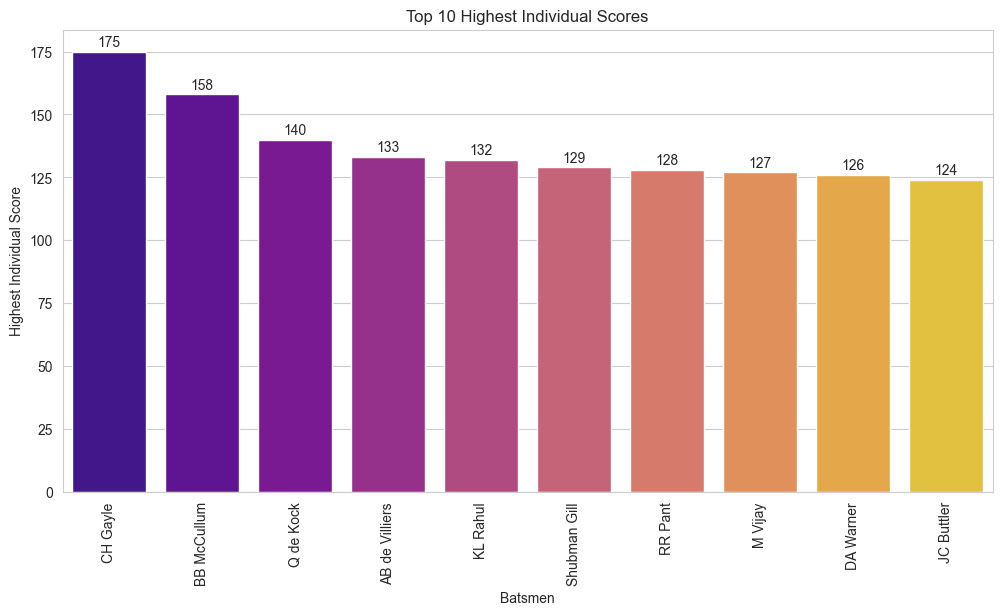

In [ ]:
top_individual_scores = deliveries.groupby(['match_id', 'batter'])['batsman_runs'].sum().reset_index()

top_individual_scores = top_individual_scores.groupby('batter', as_index=False)['batsman_runs'].max()


top_individual_scores = top_individual_scores.nlargest(10, 'batsman_runs').sort_values(by='batsman_runs', ascending=False)


plt.figure(figsize=(12, 6))
sns.barplot(x=top_individual_scores['batter'], y=top_individual_scores['batsman_runs'], palette='plasma', errorbar=None)
plt.xticks(rotation=90)
plt.xlabel('Batsmen')
plt.ylabel('Highest Individual Score')
plt.title('Top 10 Highest Individual Scores')

for i, v in enumerate(top_individual_scores['batsman_runs'].values):
    plt.text(i, v + 1, f"{v}", ha='center', va='bottom', fontsize=10)

plt.show()



## Top 10 Man of the Match Winners

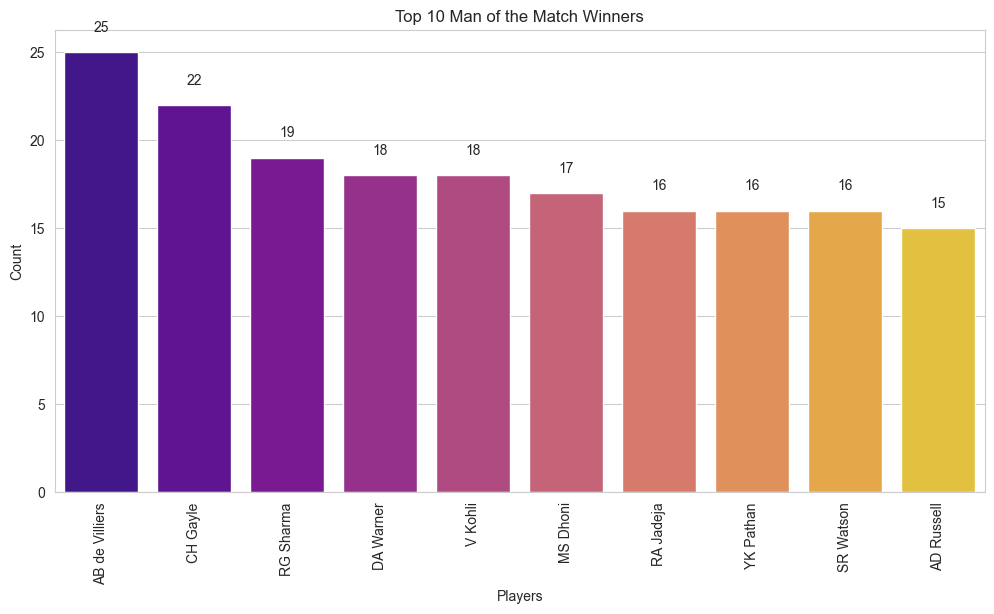

In [ ]:
mom_counts = matches['player_of_match'].value_counts().nlargest(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=mom_counts.index, y=mom_counts.values, palette='plasma')
plt.xticks(rotation=90)
plt.xlabel('Players')
plt.ylabel('Count')
plt.title('Top 10 Man of the Match Winners')

for i, v in enumerate(mom_counts.values):
    plt.text(i, v + 1, f"{v}", ha='center', va='bottom', fontsize=10)

plt.show()


## K-Means Clustering of Players

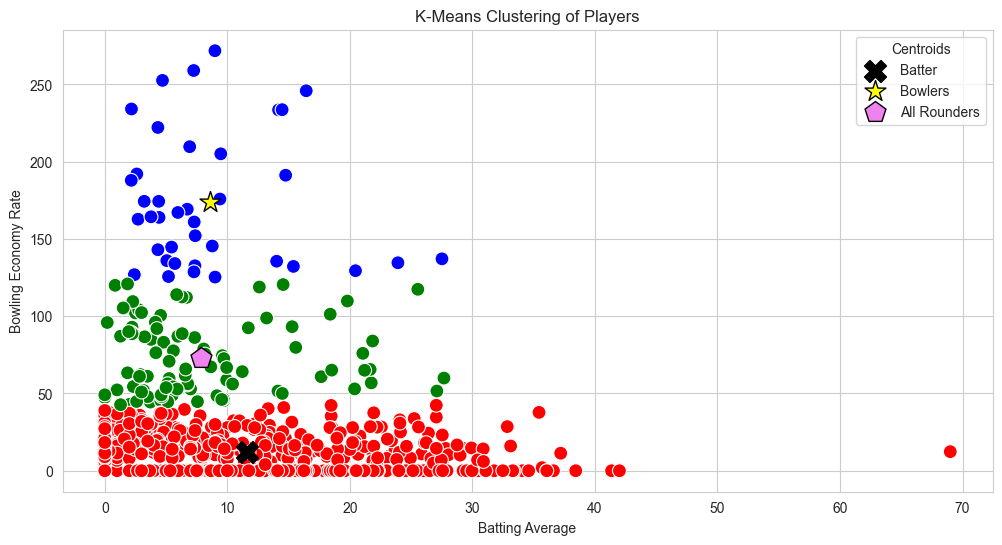

In [ ]:
player_stats = deliveries.groupby('batter').agg({'batsman_runs': 'sum', 'ball': 'count'})
bowler_stats = deliveries.groupby('bowler').agg({'total_runs': 'sum', 'over': 'nunique'})
player_stats['Batting Average'] = player_stats['batsman_runs'] / deliveries.groupby('batter')['match_id'].nunique()
bowler_stats['Economy Rate'] = bowler_stats['total_runs'] / bowler_stats['over']
merged_stats = pd.merge(player_stats, bowler_stats, left_index=True, right_index=True, how='outer').fillna(0)

kmeans = KMeans(n_clusters=3, random_state=42).fit(merged_stats[['Batting Average', 'Economy Rate']])
merged_stats['Cluster'] = kmeans.labels_

centroids = kmeans.cluster_centers_

cluster_colors = ['red', 'blue', 'green']
cluster_mark_colors = ['black', 'yellow', 'violet']
centroid_markers = ['X', '*', 'p']
centroid_labels = ['Batter', 'Bowlers', 'All Rounders']


plt.figure(figsize=(12, 6))
sns.scatterplot(x=merged_stats['Batting Average'], y=merged_stats['Economy Rate'], hue=merged_stats['Cluster'], palette=cluster_colors, s=100)


centroid_handles = []
for i, (x, y) in enumerate(centroids):
    scatter = plt.scatter(x, y, c=cluster_mark_colors[i], marker=centroid_markers[i], s=250, edgecolors='black', label=centroid_labels[i])
    centroid_handles.append(scatter)

plt.xlabel('Batting Average')
plt.ylabel('Bowling Economy Rate')
plt.title('K-Means Clustering of Players')

plt.legend(handles=centroid_handles, title="Centroids", loc='upper right')

plt.show()


## Top 10 Batsmen with Most 1s, 2s, 4s and 6s

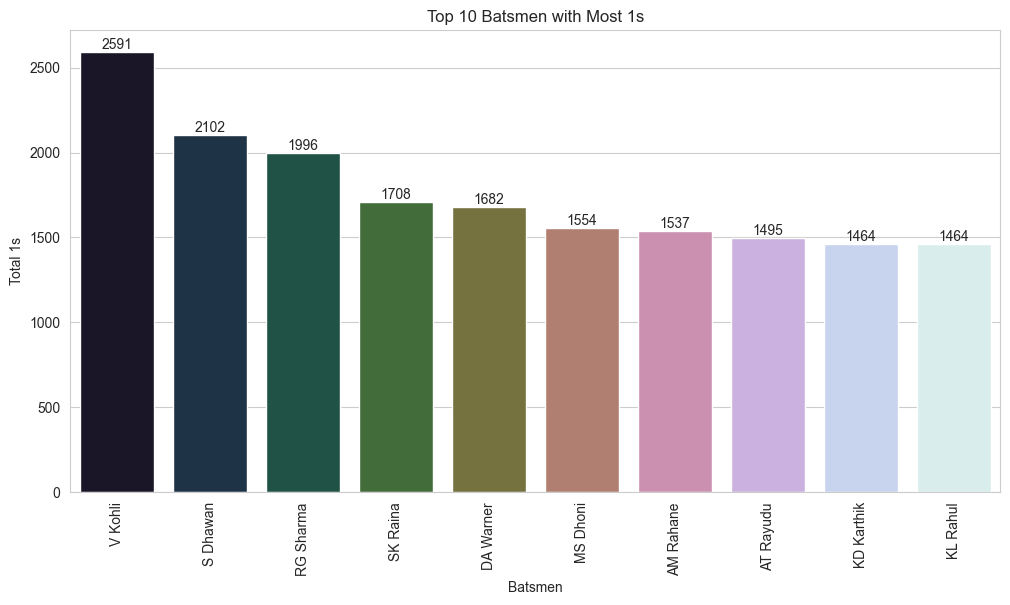

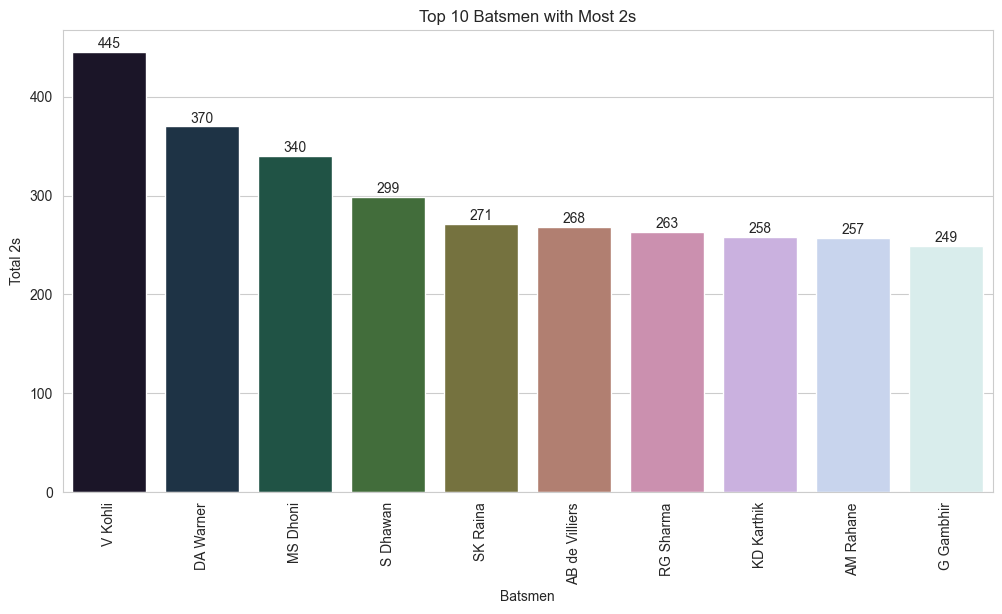

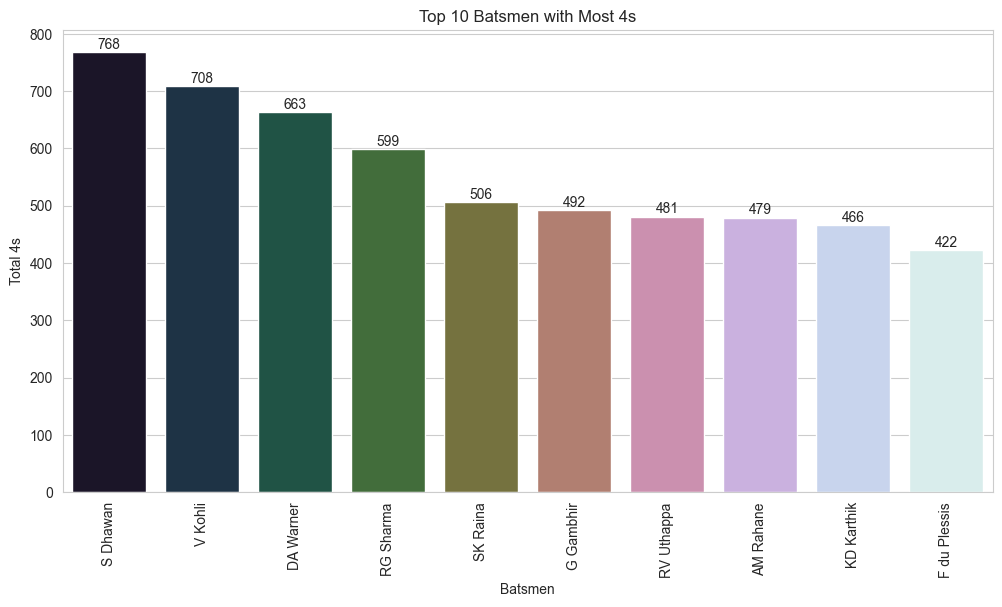

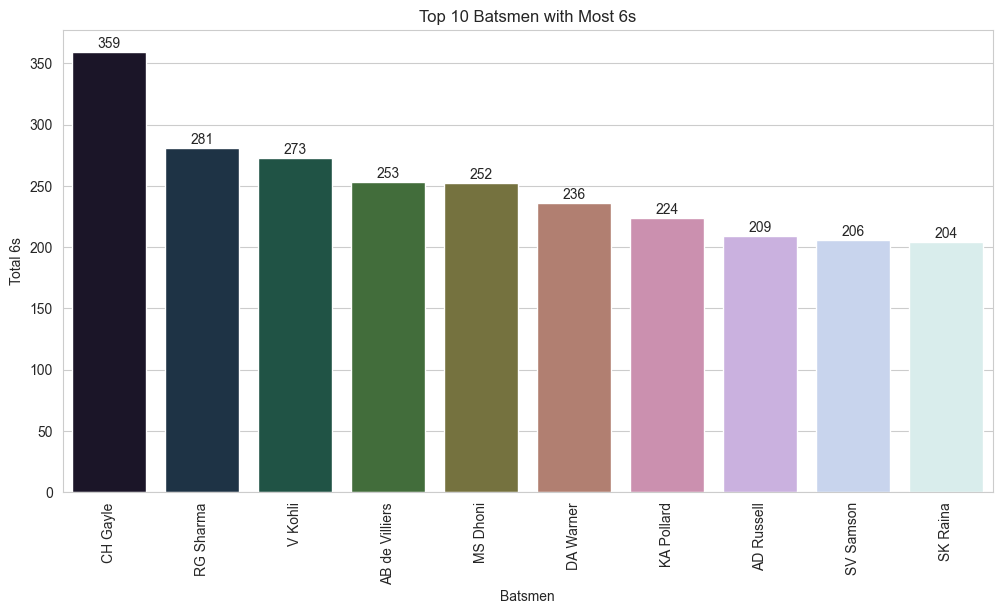

In [ ]:
run_types = {1: '1s', 2: '2s', 4: '4s', 6: '6s'}
for run, label in run_types.items():
    top_scorers = deliveries[deliveries['batsman_runs'] == run].groupby('batter')['batsman_runs'].count().nlargest(10)
    plt.figure(figsize=(12, 6))
    sns.barplot(x=top_scorers.index, y=top_scorers.values, palette='cubehelix')
    plt.xticks(rotation=90)
    plt.xlabel('Batsmen')
    plt.ylabel(f'Total {label}')
    plt.title(f'Top 10 Batsmen with Most {label}')
    for i, v in enumerate(top_scorers.values):
        plt.text(i, v + 1, f"{v}", ha='center', va='bottom', fontsize=10)
    plt.show()


# Season Analysis

## Average Runs per Match per Season

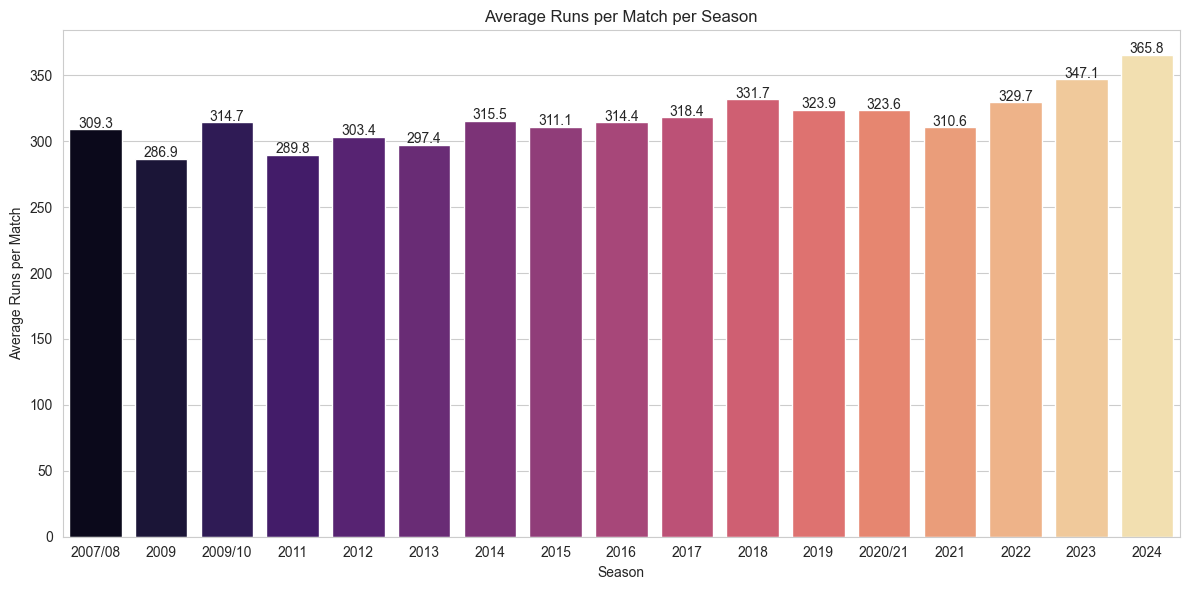

In [ ]:
season_runs = deliveries.groupby('match_id')['total_runs'].sum().reset_index()

season_runs['season'] = season_runs['match_id'].map(matches.set_index('id')['season'])

season_avg_runs = season_runs.groupby('season')['total_runs'].mean()

plt.figure(figsize=(12, 6))
sns.barplot(x=season_avg_runs.index, y=season_avg_runs.values, palette='magma')

plt.xlabel("Season")
plt.ylabel("Average Runs per Match")
plt.title("Average Runs per Match per Season")

for i, v in enumerate(season_avg_runs.values):
    plt.text(i, v + 1, f"{v:.1f}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()


## Number of 200+ Targets per Season

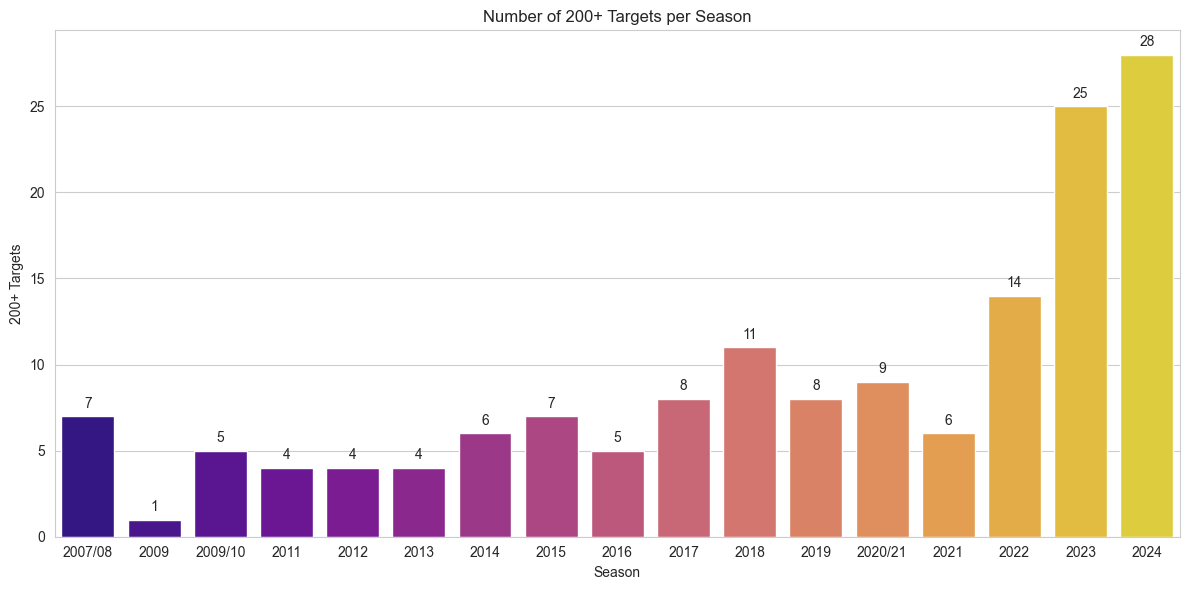

In [ ]:
high_targets = matches[matches['target_runs'] >= 200].groupby('season').size()

plt.figure(figsize=(12, 6))
sns.barplot(x=high_targets.index, y=high_targets.values, palette='plasma')

plt.xlabel("Season")
plt.ylabel("200+ Targets")
plt.title("Number of 200+ Targets per Season")

for i, v in enumerate(high_targets.values):
    plt.text(i, v + 0.5, str(v), ha='center', fontsize=10)

plt.tight_layout()
plt.show()

## Average Team Scores Per Season

In [ ]:
from tabulate import tabulate

team_runs = deliveries.groupby(['match_id', 'batting_team'])['total_runs'].sum().reset_index()

team_runs['season'] = team_runs['match_id'].map(matches.set_index('id')['season'])

avg_team_scores_per_season = team_runs.groupby(['batting_team', 'season'])['total_runs'].mean().reset_index()

avg_team_scores_per_season.columns = ['Team', 'Season', 'Avg_Score']

avg_team_scores_per_season['Avg_Score'] = avg_team_scores_per_season['Avg_Score'].round(2)

print(tabulate(avg_team_scores_per_season, headers='keys', tablefmt='pretty'))
avg_team_scores_per_season.to_csv('avg_team_scores_per_season.csv', index=False)


+-----+-----------------------------+---------+-----------+
|     |            Team             | Season  | Avg_Score |
+-----+-----------------------------+---------+-----------+
|  0  |     Chennai Super Kings     | 2007/08 |   157.5   |
|  1  |     Chennai Super Kings     |  2009   |  159.36   |
|  2  |     Chennai Super Kings     | 2009/10 |  162.75   |
|  3  |     Chennai Super Kings     |  2011   |   160.0   |
|  4  |     Chennai Super Kings     |  2012   |  157.28   |
|  5  |     Chennai Super Kings     |  2013   |  154.33   |
|  6  |     Chennai Super Kings     |  2014   |  165.62   |
|  7  |     Chennai Super Kings     |  2015   |  160.29   |
|  8  |     Chennai Super Kings     |  2018   |  175.56   |
|  9  |     Chennai Super Kings     |  2019   |  145.47   |
| 10  |     Chennai Super Kings     | 2020/21 |   156.5   |
| 11  |     Chennai Super Kings     |  2021   |  170.81   |
| 12  |     Chennai Super Kings     |  2022   |  163.43   |
| 13  |     Chennai Super Kings     |  2

## Orange Cap holders of every season

In [ ]:
deliveries['season'] = deliveries['match_id'].map(matches.set_index('id')['season'])

batsman_runs_per_season = deliveries.groupby(['season', 'batter'])['batsman_runs'].sum().reset_index()

orange_cap_holders = batsman_runs_per_season.loc[batsman_runs_per_season.groupby('season')['batsman_runs'].idxmax()]

orange_cap_holders.columns = ['Season', 'Batter', 'Total_Runs']

orange_cap_holders['Total_Runs'] = orange_cap_holders['Total_Runs'].astype(int)

print(tabulate(orange_cap_holders, headers='keys', tablefmt='pretty', showindex=False))

orange_cap_holders.to_csv('orange_cap_holders.csv', index=False)


+---------+---------------+------------+
| Season  |    Batter     | Total_Runs |
+---------+---------------+------------+
| 2007/08 |   SE Marsh    |    616     |
|  2009   |   ML Hayden   |    572     |
| 2009/10 | SR Tendulkar  |    618     |
|  2011   |   CH Gayle    |    608     |
|  2012   |   CH Gayle    |    733     |
|  2013   |  MEK Hussey   |    733     |
|  2014   |  RV Uthappa   |    660     |
|  2015   |   DA Warner   |    562     |
|  2016   |    V Kohli    |    973     |
|  2017   |   DA Warner   |    641     |
|  2018   | KS Williamson |    735     |
|  2019   |   DA Warner   |    692     |
| 2020/21 |   KL Rahul    |    676     |
|  2021   |  RD Gaikwad   |    635     |
|  2022   |  JC Buttler   |    863     |
|  2023   | Shubman Gill  |    890     |
|  2024   |    V Kohli    |    741     |
+---------+---------------+------------+


## Purple Cap holders of every season

In [ ]:
deliveries['season'] = deliveries['match_id'].map(matches.set_index('id')['season'])

wicket_deliveries = deliveries[deliveries['is_wicket'] == 1]

bowler_wickets_per_season = wicket_deliveries.groupby(['season', 'bowler']).size().reset_index(name='wickets')

purple_cap_holders = bowler_wickets_per_season.loc[bowler_wickets_per_season.groupby('season')['wickets'].idxmax()]

purple_cap_holders.columns = ['Season', 'Bowler', 'Total_Wickets']

purple_cap_holders['Total_Wickets'] = purple_cap_holders['Total_Wickets'].astype(int)

print(tabulate(purple_cap_holders, headers='keys', tablefmt='pretty', showindex=False))

purple_cap_holders.to_csv('purple_cap_holders.csv', index=False)


+---------+---------------+---------------+
| Season  |    Bowler     | Total_Wickets |
+---------+---------------+---------------+
| 2007/08 | Sohail Tanvir |      24       |
|  2009   |   RP Singh    |      26       |
| 2009/10 |    PP Ojha    |      22       |
|  2011   |  SL Malinga   |      30       |
|  2012   |   M Morkel    |      30       |
|  2013   |   DJ Bravo    |      34       |
|  2014   |   MM Sharma   |      26       |
|  2015   |   DJ Bravo    |      28       |
|  2016   |    B Kumar    |      24       |
|  2017   |    B Kumar    |      28       |
|  2018   |    AJ Tye     |      28       |
|  2019   |   K Rabada    |      29       |
| 2020/21 |   K Rabada    |      32       |
|  2021   |   HV Patel    |      35       |
|  2022   |   YS Chahal   |      29       |
|  2023   |   MM Sharma   |      31       |
|  2024   |   HV Patel    |      30       |
+---------+---------------+---------------+


## Top 10 Bowlers per Season

In [ ]:
deliveries['season'] = deliveries['match_id'].map(matches.set_index('id')['season'])

wicket_deliveries = deliveries[deliveries['is_wicket'] == 1]

bowler_wickets_per_season = wicket_deliveries.groupby(['season', 'bowler']).size().reset_index(name='wickets')

bowler_wickets_per_season = bowler_wickets_per_season.sort_values(['season', 'wickets'], ascending=[True, False])

top_10_bowlers_per_season = bowler_wickets_per_season.groupby('season').head(10).reset_index(drop=True)

top_10_bowlers_per_season['wickets'] = top_10_bowlers_per_season['wickets'].astype(int)

print(tabulate(top_10_bowlers_per_season, headers='keys', tablefmt='pretty', showindex=False))

top_10_bowlers_per_season.to_csv('top_10_bowlers_per_season.csv', index=False)


+---------+-------------------+---------+
| season  |      bowler       | wickets |
+---------+-------------------+---------+
| 2007/08 |   Sohail Tanvir   |   24    |
| 2007/08 |     IK Pathan     |   20    |
| 2007/08 |     JA Morkel     |   20    |
| 2007/08 |     SK Warne      |   20    |
| 2007/08 |     SR Watson     |   20    |
| 2007/08 |    MF Maharoof    |   19    |
| 2007/08 |     PP Chawla     |   19    |
| 2007/08 |    S Sreesanth    |   19    |
| 2007/08 |      MS Gony      |   18    |
| 2007/08 |     RP Singh      |   17    |
|  2009   |     RP Singh      |   26    |
|  2009   |     A Kumble      |   22    |
|  2009   |      A Nehra      |   22    |
|  2009   |      PP Ojha      |   21    |
|  2009   |    SL Malinga     |   21    |
|  2009   |     DP Nannes     |   20    |
|  2009   |     IK Pathan     |   20    |
|  2009   |     MM Patel      |   18    |
|  2009   |    PJ Sangwan     |   18    |
|  2009   |  M Muralitharan   |   16    |
| 2009/10 |      PP Ojha      |   

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings
warnings.filterwarnings("ignore")

In [ ]:
with open('team_name_correction.json', 'r') as f:
    team_name_correction = json.load(f)

In [ ]:
df=pd.read_csv("deliveries.csv")
df=df.replace(team_name_correction)

In [ ]:
df.columns

Index(['match_id', 'inning', 'batting_team', 'bowling_team', 'over', 'ball',
       'batter', 'bowler', 'non_striker', 'batsman_runs', 'extra_runs',
       'total_runs', 'extras_type', 'is_wicket', 'player_dismissed',
       'dismissal_kind', 'fielder'],
      dtype='object')

#####  Successful opening Partnership

In [ ]:


partnerships = df.groupby(["batter", "non_striker"])["total_runs"].sum().reset_index()
partnerships = partnerships.sort_values(by="total_runs", ascending=False)
print(partnerships.head(10))


              batter     non_striker  total_runs
324   AB de Villiers         V Kohli        1623
1477        CH Gayle         V Kohli        1617
8499         V Kohli  AB de Villiers        1511
1795       DA Warner        S Dhawan        1420
8509         V Kohli        CH Gayle        1185
6798      RV Uthappa       G Gambhir        1077
8519         V Kohli    F du Plessis        1050
2918    Ishan Kishan       RG Sharma         992
2361    F du Plessis         V Kohli         982
6995        S Dhawan       DA Warner         937


#####  Average Powerplay Runs

In [ ]:
powerplay = df[df["over"] <= 6].groupby(["match_id", "batting_team"])["total_runs"].sum().reset_index()
avg_powerplay = powerplay.groupby("batting_team")["total_runs"].mean().reset_index()
avg_powerplay = avg_powerplay.sort_values(by="total_runs", ascending=False)
print(avg_powerplay)


                   batting_team  total_runs
2                Gujarat Titans   57.626667
1                Delhi Capitals   55.003968
7                  Punjab Kings   54.983740
3          Kochi Tuskers Kerala   54.928571
11          Sunrisers Hyderabad   54.704280
4         Kolkata Knight Riders   54.310757
5          Lucknow Super Giants   53.522727
8              Rajasthan Royals   53.518182
6                Mumbai Indians   53.421456
0           Chennai Super Kings   53.295359
10  Royal Challengers Bengaluru   52.635294
9       Rising Pune Supergiants   50.160000


#####  Wickets Per Over

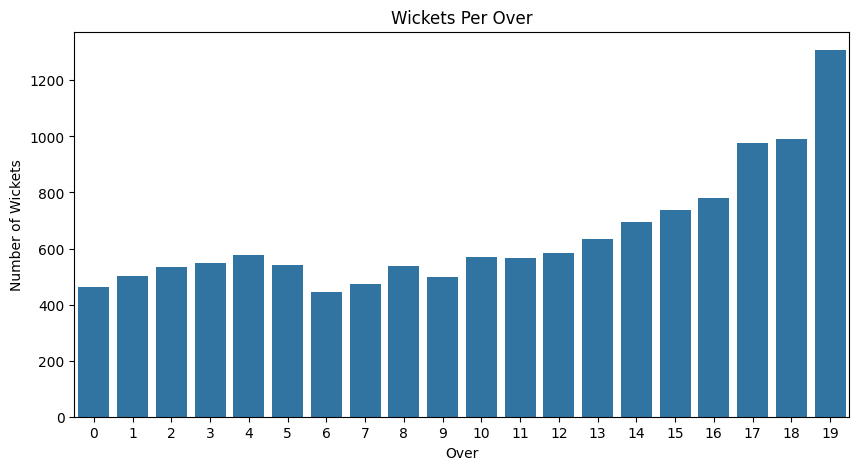

In [ ]:
wicket_stats = df[df["is_wicket"] == 1].groupby("over")["is_wicket"].count().reset_index()
plt.figure(figsize=(10, 5))
sns.barplot(x=wicket_stats["over"], y=wicket_stats["is_wicket"])
plt.title("Wickets Per Over")
plt.xlabel("Over")
plt.ylabel("Number of Wickets")
plt.show()


#####  4s vs 6s perTeam

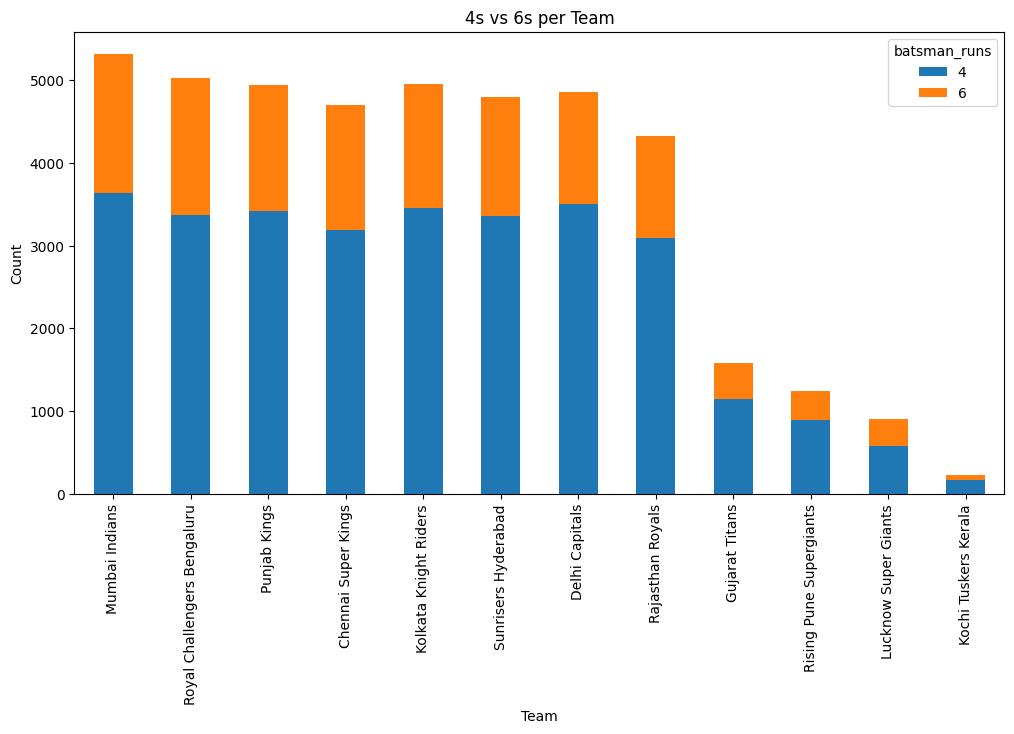

In [ ]:
boundaries = df[df["batsman_runs"].isin([4, 6])].groupby(["batting_team", "batsman_runs"])["batsman_runs"].count().unstack().sort_values(by=6, ascending=False)
boundaries.plot(kind="bar", stacked=True, figsize=(12, 6))
plt.title("4s vs 6s per Team")
plt.xlabel("Team")
plt.ylabel("Count")
plt.show()


#####  No of Catch Dismissal by a bowler

In [ ]:
caught_outs = df[df["dismissal_kind"] == "caught"].groupby("bowler")["player_dismissed"].count().reset_index()
caught_outs = caught_outs.sort_values(by="player_dismissed", ascending=False)
print(caught_outs.head(10))


        bowler  player_dismissed
95    DJ Bravo               143
430  YS Chahal               127
57     B Kumar               122
294   R Ashwin               117
405   UT Yadav               108
161  JJ Bumrah               108
132   HV Patel               107
242  MM Sharma               102
6     A Mishra               102
178   K Rabada                97


#####  Average Wickets Fall per 5-over Interval

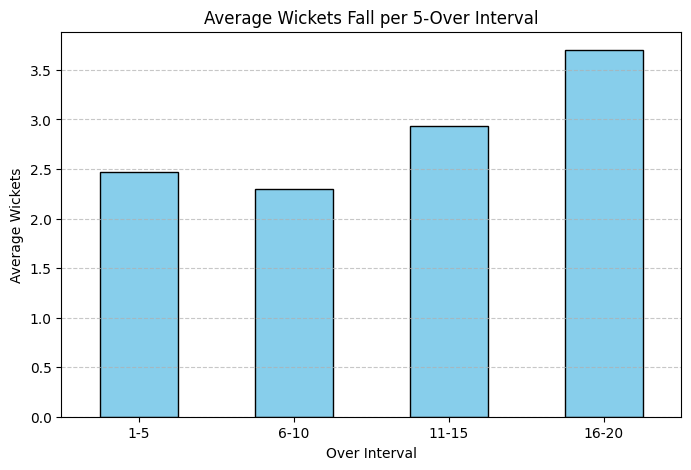

In [ ]:
wickets_df = df[df['is_wicket'] == 1]
wickets_df['over_interval'] = pd.cut(wickets_df['over'], bins=[0, 5, 10, 15, 20], labels=['1-5', '6-10', '11-15', '16-20'])
avg_wickets_per_over = wickets_df.groupby('over_interval').size() / df['match_id'].nunique()
plt.figure(figsize=(8, 5))
avg_wickets_per_over.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Average Wickets Fall per 5-Over Interval')
plt.xlabel('Over Interval')
plt.ylabel('Average Wickets')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#####  Top 10 Bowlers by Economy Rate

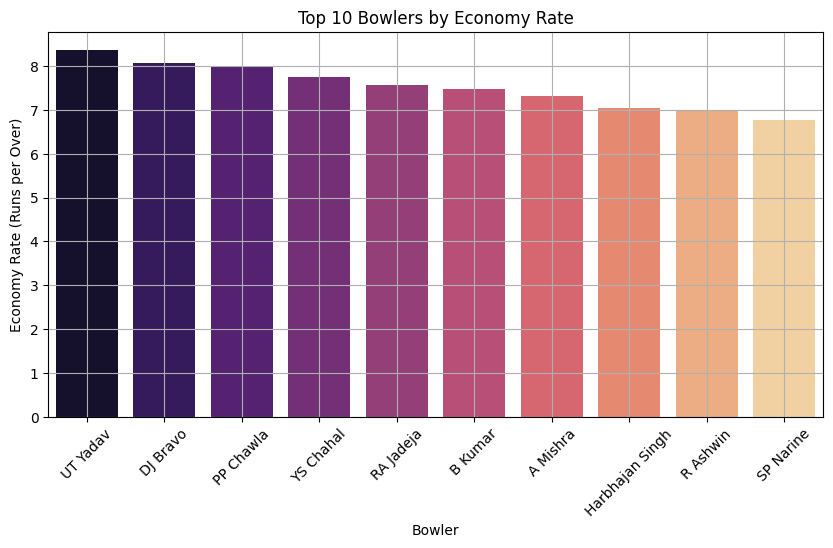

In [ ]:
bowler_stats = (
    df.groupby("bowler")
    .agg(runs_conceded=("total_runs", "sum"), balls_bowled=("ball", "count"))
    .reset_index()
)

bowler_stats["overs_bowled"] = bowler_stats["balls_bowled"] / 6
bowler_stats["economy_rate"] = bowler_stats["runs_conceded"] / bowler_stats["overs_bowled"]
top_bowlers = bowler_stats.sort_values("overs_bowled", ascending=False).head(10)
top_bowlers=top_bowlers.sort_values(by="economy_rate", ascending=False)
plt.figure(figsize=(10, 5))
sns.barplot(data=(top_bowlers), x="bowler", y="economy_rate", palette="magma")
plt.xlabel("Bowler")
plt.ylabel("Economy Rate (Runs per Over)")
plt.title("Top 10 Bowlers by Economy Rate")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings
warnings.filterwarnings("ignore")

In [ ]:
with open('team_name_correction.json', 'r') as f:
    team_name_correction = json.load(f)

with open('stadium_name_correction.json', 'r') as f:
    stadium_name_correction = json.load(f)

df=pd.read_csv("matches.csv")
df=df.replace(team_name_correction)
df=df.replace(stadium_name_correction)

#### Toss winner vs Old Winner

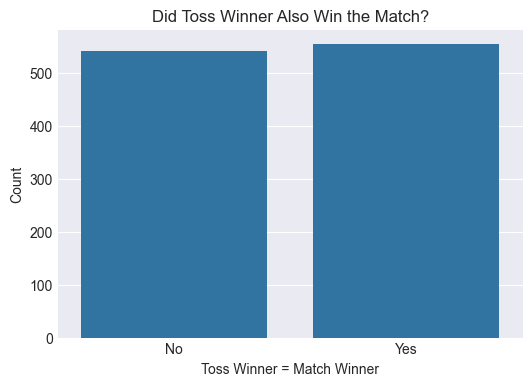

In [ ]:
df["toss_win_match_win"] = df["toss_winner"] == df["winner"]

plt.figure(figsize=(6, 4))
sns.countplot(x="toss_win_match_win", data=df)
plt.title("Did Toss Winner Also Win the Match?")
plt.xlabel("Toss Winner = Match Winner")
plt.ylabel("Count")
plt.xticks([0, 1], ["No", "Yes"])
plt.show()


#### Distribution of Victory Margins (Runs)

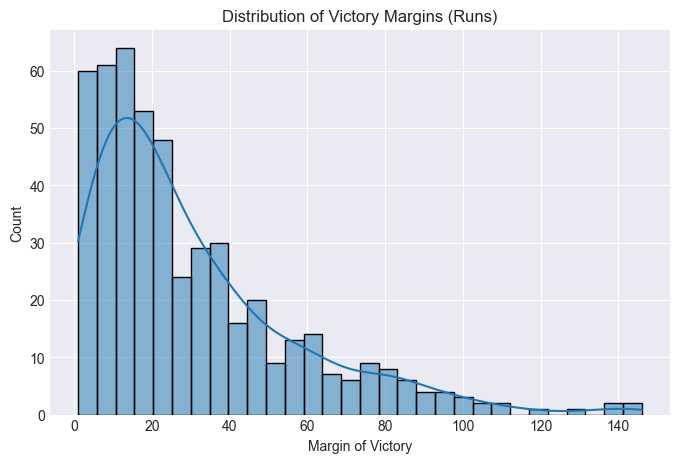

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(df[df["result"]=="runs"]["result_margin"], bins=30, kde=True)
plt.title("Distribution of Victory Margins (Runs)")
plt.xlabel("Margin of Victory")
plt.show()


#### Distribution of Victory (wickets)

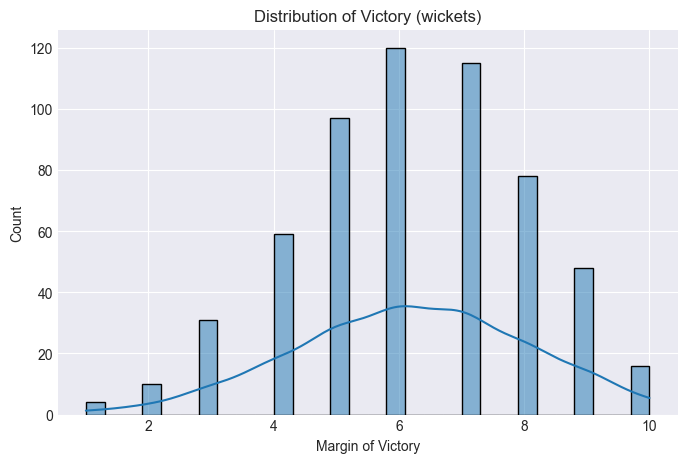

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(df[df["result"]=="wickets"]["result_margin"], bins=30, kde=True)
plt.title("Distribution of Victory (wickets)")
plt.xlabel("Margin of Victory")
plt.show()


#### Venues with most win when batting first and venues with most win when bowling first

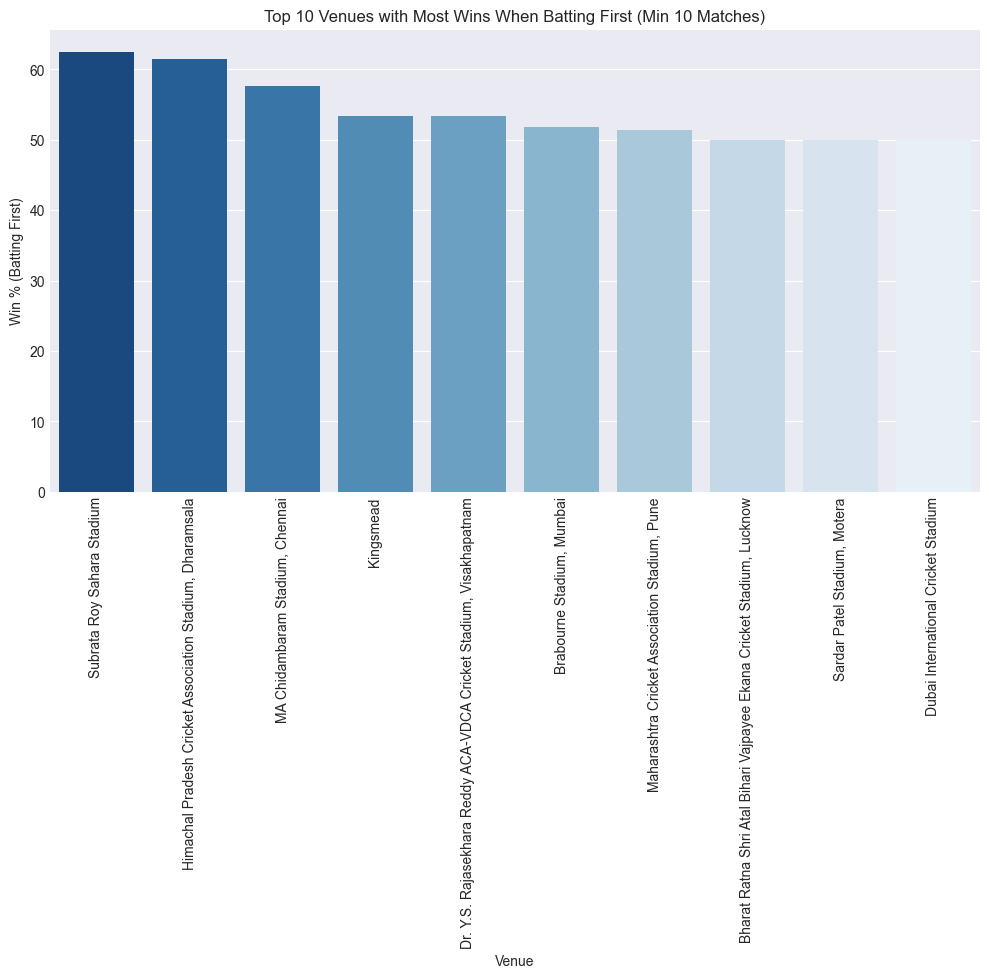

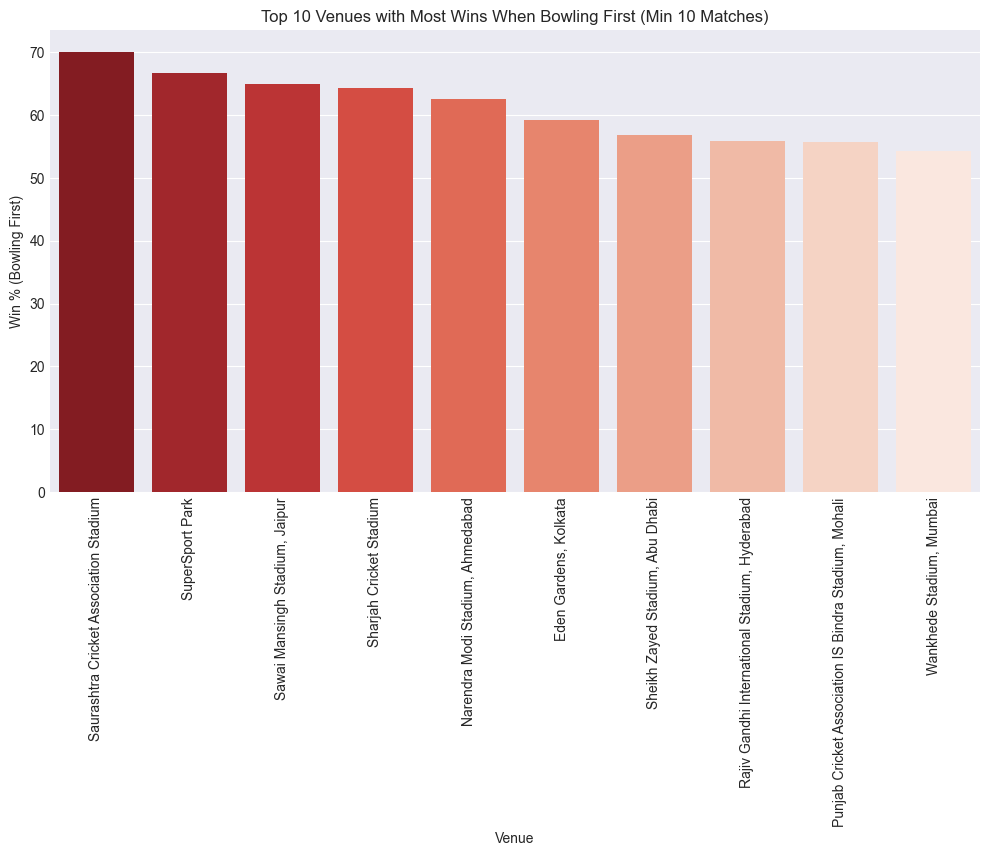

In [ ]:
df["winner_batted_first"] = (
    ((df["winner"] == df["toss_winner"]) & (df["toss_decision"] == "bat")) |
    ((df["winner"] != df["toss_winner"]) & (df["toss_decision"] == "field"))
)

df["winner_bowled_first"] = ~df["winner_batted_first"]


venue_total_matches = df["venue"].value_counts()


valid_venues = venue_total_matches[venue_total_matches >= 10].index

venue_bat_first_wins = df[df["winner_batted_first"] & df["venue"].isin(valid_venues)].groupby("venue")["winner"].count()
venue_bowl_first_wins = df[df["winner_bowled_first"] & df["venue"].isin(valid_venues)].groupby("venue")["winner"].count()

venue_bat_first_win_pct = (venue_bat_first_wins / venue_total_matches * 100).dropna().sort_values(ascending=False)
venue_bowl_first_win_pct = (venue_bowl_first_wins / venue_total_matches * 100).dropna().sort_values(ascending=False)

df["bat_first_win_pct"] = df["venue"].map(venue_bat_first_win_pct).fillna(0)
df["bowl_first_win_pct"] = df["venue"].map(venue_bowl_first_win_pct).fillna(0)


plt.figure(figsize=(12, 6))
sns.barplot(x=venue_bat_first_win_pct.index[:10], y=venue_bat_first_win_pct.values[:10], palette="Blues_r")
plt.xticks(rotation=90)
plt.title("Top 10 Venues with Most Wins When Batting First (Min 10 Matches)")
plt.xlabel("Venue")
plt.ylabel("Win % (Batting First)")
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x=venue_bowl_first_win_pct.index[:10], y=venue_bowl_first_win_pct.values[:10], palette="Reds_r")
plt.xticks(rotation=90)
plt.title("Top 10 Venues with Most Wins When Bowling First (Min 10 Matches)")
plt.xlabel("Venue")
plt.ylabel("Win % (Bowling First)")
plt.show()

#### Top 10 Players with Most Player of the Match

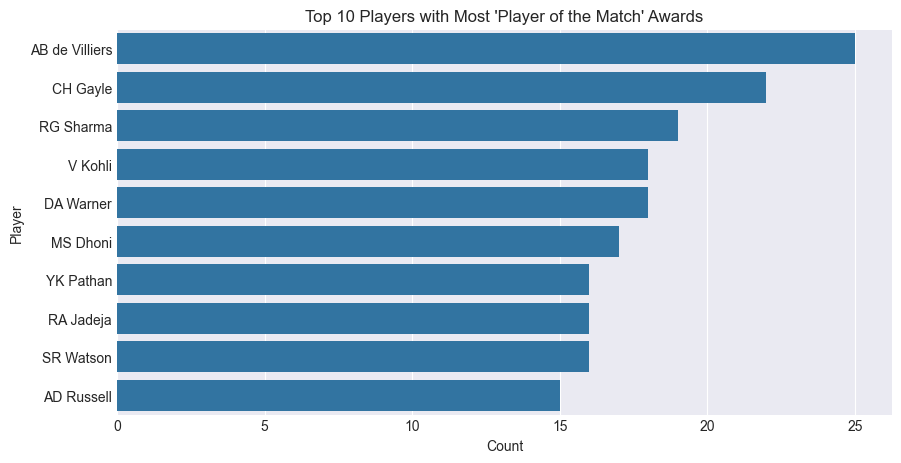

In [ ]:
top_players = df["player_of_match"].value_counts().head(10)
plt.figure(figsize=(10, 5))
sns.barplot(y=top_players.index, x=top_players.values)
plt.title("Top 10 Players with Most 'Player of the Match' Awards")
plt.xlabel("Count")
plt.ylabel("Player")
plt.show()


#### Impact of Toss win

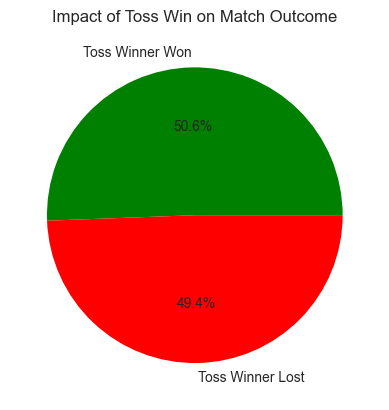

In [ ]:
toss_win = df[df["toss_winner"] == df["winner"]].shape[0]
toss_loss = df[df["toss_winner"] != df["winner"]].shape[0]

plt.pie([toss_win, toss_loss], labels=["Toss Winner Won", "Toss Winner Lost"], autopct="%1.1f%%", colors=["green", "red"])
plt.title("Impact of Toss Win on Match Outcome")
plt.show()


#### Venues with Most Super Overs

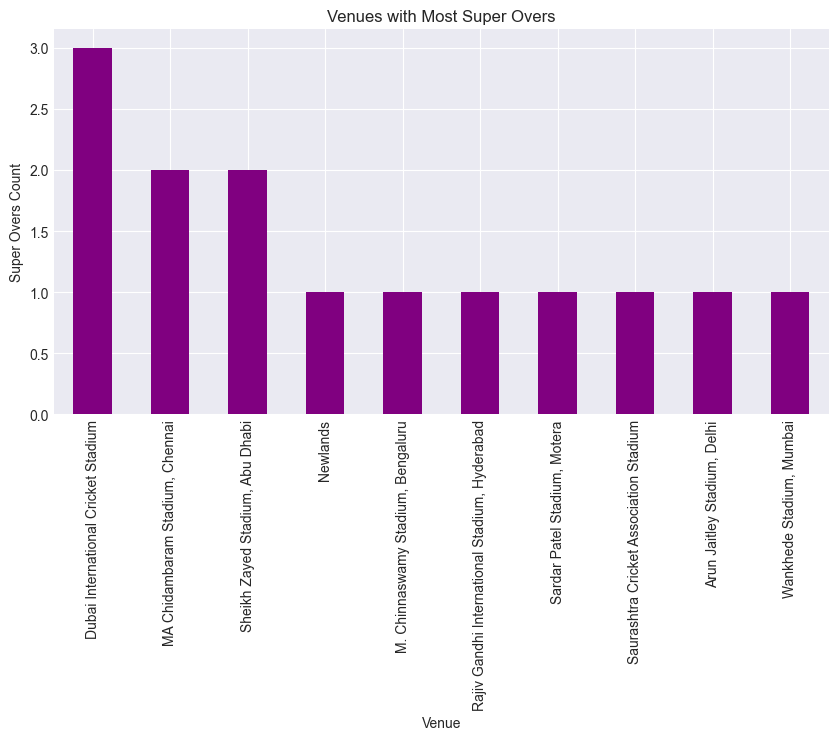

In [ ]:
super_over_venues = df[df["super_over"] == "Y"]["venue"].value_counts()
super_over_venues[:10].plot(kind="bar", figsize=(10, 5), color="purple")
plt.title("Venues with Most Super Overs")
plt.xlabel("Venue")
plt.ylabel("Super Overs Count")
plt.xticks(rotation=90)
plt.show()


#### Top 10 Teams by wins while chasing vs defending

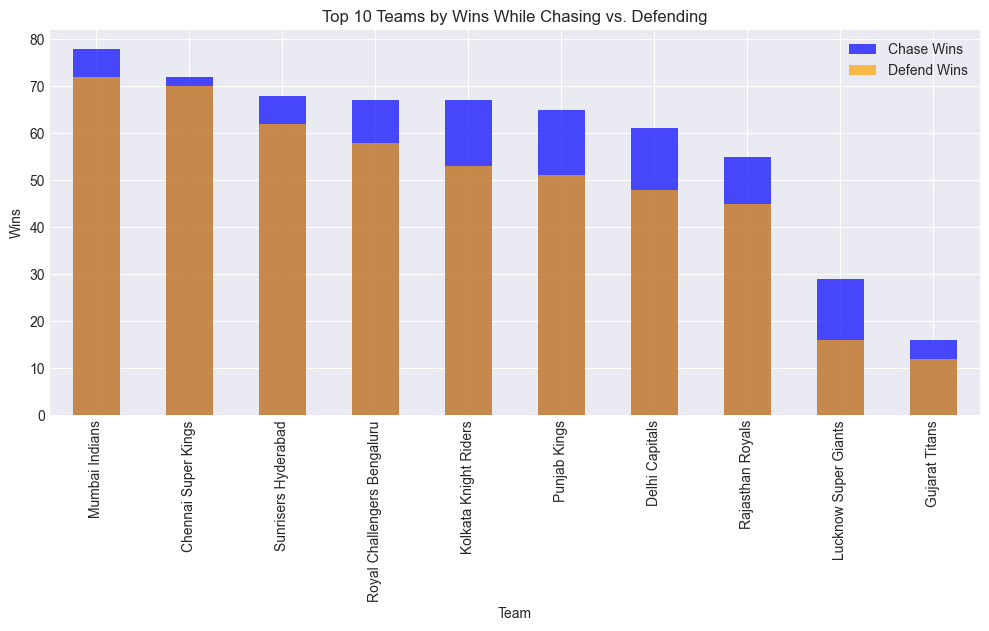

In [ ]:
df["won_batting_first"] = ((df["winner"] == df["toss_winner"]) & (df["toss_decision"] == "bat")) | \
                          ((df["winner"] != df["toss_winner"]) & (df["toss_decision"] == "field"))

team_chase_wins = df[~df["won_batting_first"]].groupby("winner")["winner"].count()
team_defend_wins = df[df["won_batting_first"]].groupby("winner")["winner"].count()


plt.figure(figsize=(12, 5))
team_chase_wins.sort_values(ascending=False)[:10].plot(kind="bar", color="blue", alpha=0.7, label="Chase Wins")
team_defend_wins.sort_values(ascending=False)[:10].plot(kind="bar", color="orange", alpha=0.7, label="Defend Wins")
plt.title("Top 10 Teams by Wins While Chasing vs. Defending")
plt.xlabel("Team")
plt.ylabel("Wins")
plt.legend()
plt.xticks(rotation=90)
plt.show()


#### Toss Decision & Winning Probability

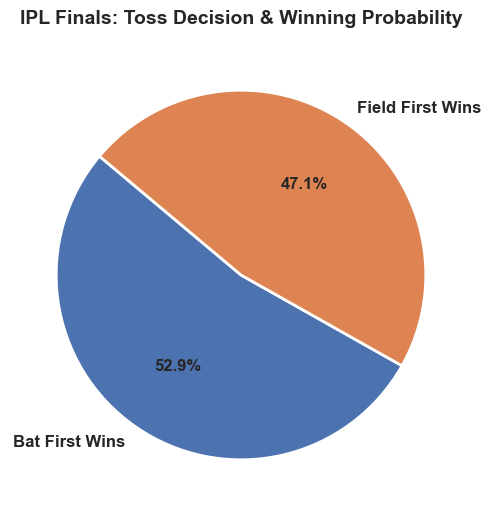

In [ ]:
plt.style.use("seaborn-v0_8-darkgrid")
finals = df[df["match_type"] == "Final"]
bat_first_wins = ((finals["toss_decision"] == "bat") & (finals["toss_winner"] == finals["winner"])).sum() + \
                 ((finals["toss_decision"] == "field") & (finals["toss_winner"] != finals["winner"])).sum()

field_first_wins = ((finals["toss_decision"] == "field") & (finals["toss_winner"] == finals["winner"])).sum() + \
                   ((finals["toss_decision"] == "bat") & (finals["toss_winner"] != finals["winner"])).sum()
colors = ["#4c72b0", "#dd8452"]
fig, ax = plt.subplots(figsize=(6, 6))
wedges, texts, autotexts = ax.pie(
    [bat_first_wins, field_first_wins],
    labels=["Bat First Wins", "Field First Wins"],
    autopct="%1.1f%%",
    colors=colors,
    startangle=140,
    wedgeprops={"edgecolor": "white", "linewidth": 2, "antialiased": True},
    textprops={"fontsize": 12, "weight": "bold"}
)
plt.title("IPL Finals: Toss Decision & Winning Probability", fontsize=14, fontweight="bold", pad=15)

plt.show()


#### Top 10 IPL venues by Match Hosted

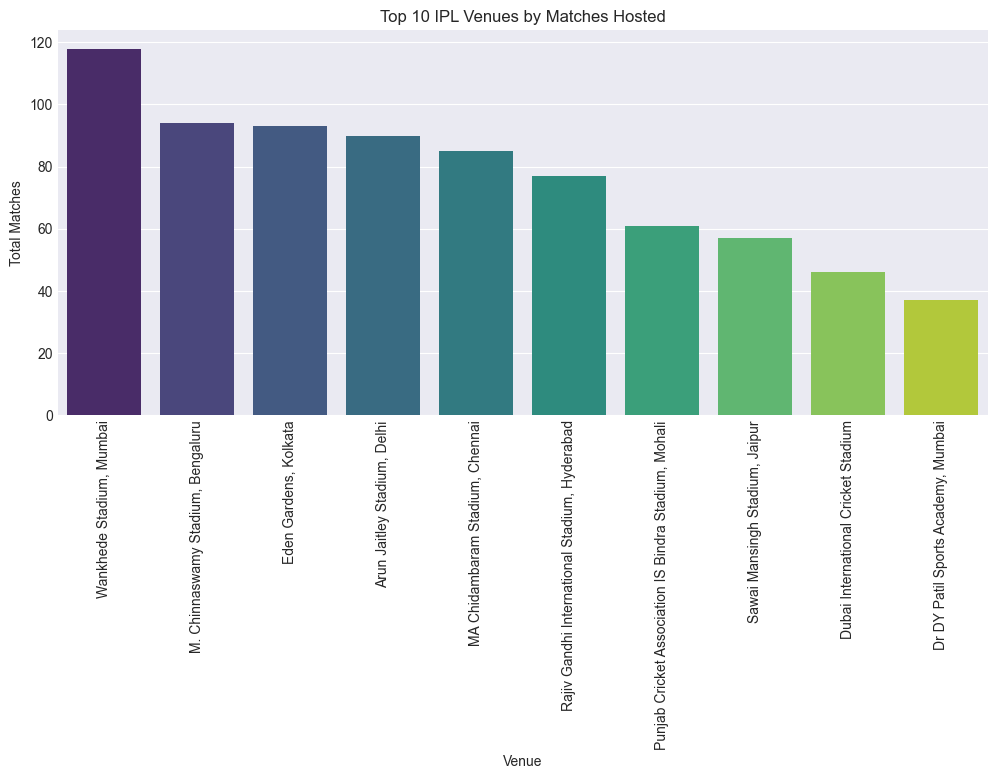

In [ ]:
venue_counts = df["venue"].value_counts()
plt.figure(figsize=(12, 5))
sns.barplot(x=venue_counts.index[:10], y=venue_counts.values[:10], palette="viridis")
plt.xticks(rotation=90)
plt.title("Top 10 IPL Venues by Matches Hosted")
plt.xlabel("Venue")
plt.ylabel("Total Matches")
plt.show()


#### Average Run chase per season

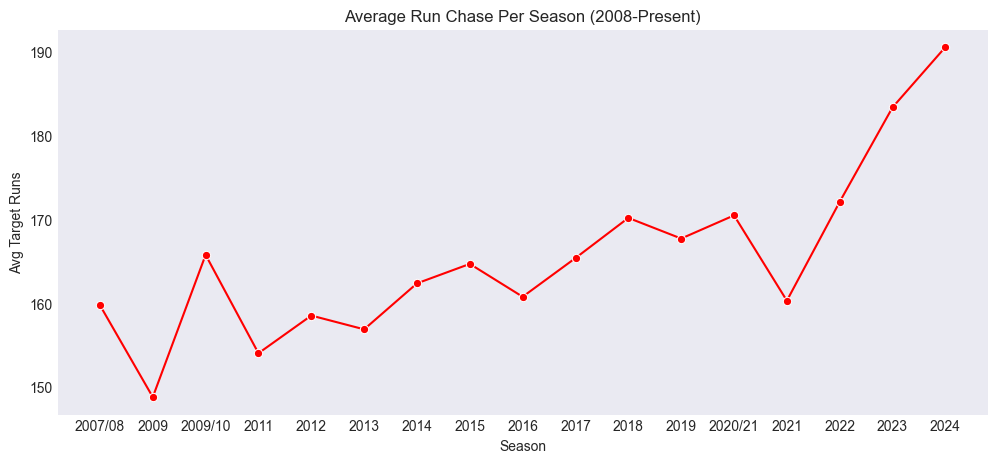

In [ ]:

avg_target_runs = df.groupby("season")["target_runs"].mean()

plt.figure(figsize=(12, 5))
sns.lineplot(x=avg_target_runs.index, y=avg_target_runs.values, marker="o", color="red")
plt.title("Average Run Chase Per Season (2008-Present)")
plt.xlabel("Season")
plt.ylabel("Avg Target Runs")
plt.grid()
plt.show()


#### Effect of rain on wins: Bat first vs field first

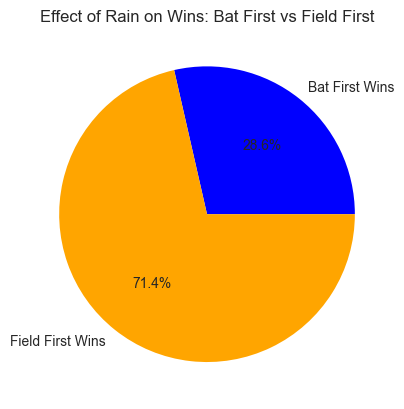

In [ ]:

rain_affected = df[df["method"].notna()]


bat_first_rain_wins = rain_affected[(rain_affected["toss_decision"] == "bat") & (rain_affected["toss_winner"] == rain_affected["winner"])].shape[0] + \
                       rain_affected[(rain_affected["toss_decision"] == "field") & (rain_affected["toss_winner"] != rain_affected["winner"])].shape[0]

field_first_rain_wins = rain_affected[(rain_affected["toss_decision"] == "field") & (rain_affected["toss_winner"] == rain_affected["winner"])].shape[0] + \
                         rain_affected[(rain_affected["toss_decision"] == "bat") & (rain_affected["toss_winner"] != rain_affected["winner"])].shape[0]


plt.pie([bat_first_rain_wins, field_first_rain_wins], labels=["Bat First Wins", "Field First Wins"], autopct="%1.1f%%", colors=["blue", "orange"])
plt.title("Effect of Rain on Wins: Bat First vs Field First")
plt.show()

In [ ]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import json


### Prediction Pipeline Flow

##### Toss Prediction --> Decision Prediction --> Final Prediction

In [ ]:
### Loading Data Cleaning files

with open('team_name_correction.json', 'r') as f:
    team_name_correction = json.load(f)

with open('team_mapping.json', 'r') as f:
    team_mapping = json.load(f)

with open('stadium_mapping.json', 'r') as f:
    stadium_mapping = json.load(f)

with open('stadium_name_correction.json', 'r') as f:
    stadium_name_correction = json.load(f)


with open('reverse_team_mapping.json', 'r') as f:
    reverse_team_mapping = json.load(f)

In [ ]:
balls_df=pd.read_csv('deliveries.csv')
balls_df = balls_df.replace(team_name_correction)

In [ ]:
matches_df=pd.read_csv('matches.csv')
matches_df = matches_df.replace(team_name_correction)
matches_df = matches_df.replace(stadium_name_correction)


###  Toss_Model

In [ ]:
toss_data=matches_df[['team1','team2','toss_winner']]
toss_data=toss_data.replace(team_mapping)

Toss Training

In [ ]:
from sklearn.ensemble import RandomForestClassifier
Toss_Model = RandomForestClassifier(
    n_estimators=20,
    max_depth=15,
    random_state=42
)

In [ ]:
mai=toss_data.drop('toss_winner',axis=1)
target=toss_data['toss_winner']

In [ ]:
Toss_Model.fit(mai,target)

RandomForestClassifier(max_depth=15, n_estimators=20, random_state=42)

Toss Prediction

In [ ]:
a="Kolkata Knight Riders"
b="Chennai Super Kings"
print(reverse_team_mapping.get(str(Toss_Model.predict([[team_mapping[a],team_mapping[b]]])[0])))


Chennai Super Kings


### Decision after wining Toss

Toss_Model Training

In [ ]:
decision_making=matches_df[['team1','team2','toss_winner','toss_decision','venue']]

In [ ]:
decision_making=decision_making.replace(team_mapping)
decision_making=decision_making.replace(stadium_mapping)
decision_making['toss_decision']=decision_making['toss_decision'].map({'field':0,'bat':1})

In [ ]:
decision_making

,team1,team2,toss_winner,toss_decision,venue
0,3,0,3,0,1
1,5,1,1,1,2
2,6,2,2,1,3
3,7,3,7,1,4
4,0,4,4,1,5
...,...,...,...,...,...
1090,5,4,5,1,7
1091,4,0,4,1,35
1092,3,2,2,0,35
1093,4,2,2,0,8


In [ ]:
inp=decision_making.drop('toss_decision',axis=1)
out=decision_making['toss_decision']

In [ ]:
Toss_Decision_Model = RandomForestClassifier(
    n_estimators=20,
    max_depth=15,
    random_state=42
)

In [ ]:
Toss_Decision_Model.fit(inp,out)

RandomForestClassifier(max_depth=15, n_estimators=20, random_state=42)

Decision Prediction

In [ ]:
a="Kolkata Knight Riders"
b="Chennai Super Kings"
toss_won="Chennai Super Kings"
venue="Nehru Stadium"

decision=int(Toss_Decision_Model.predict([[team_mapping[a],team_mapping[b],team_mapping[toss_won],stadium_mapping[venue]]])[0])

print("Field" if decision==0 else "Bat")

Field


### Final Toss_Model

# Preparing Dataset

In [ ]:
matches_df.head()

,id,season,city,date,match_type,player_of_match,venue,team1,team2,toss_winner,toss_decision,winner,result,result_margin,target_runs,target_overs,super_over,method,umpire1,umpire2
0,335982,2007/08,Bangalore,2008-04-18,League,BB McCullum,"M. Chinnaswamy Stadium, Bengaluru",Royal Challengers Bengaluru,Kolkata Knight Riders,Royal Challengers Bengaluru,field,Kolkata Knight Riders,runs,140.0,223.0,20.0,N,NaN,Asad Rauf,RE Koertzen
1,335983,2007/08,Chandigarh,2008-04-19,League,MEK Hussey,"Punjab Cricket Association IS Bindra Stadium, ...",Punjab Kings,Chennai Super Kings,Chennai Super Kings,bat,Chennai Super Kings,runs,33.0,241.0,20.0,N,NaN,MR Benson,SL Shastri
2,335984,2007/08,Delhi,2008-04-19,League,MF Maharoof,"Arun Jaitley Stadium, Delhi",Delhi Capitals,Rajasthan Royals,Rajasthan Royals,bat,Delhi Capitals,wickets,9.0,130.0,20.0,N,NaN,Aleem Dar,GA Pratapkumar
3,335985,2007/08,Mumbai,2008-04-20,League,MV Boucher,"Wankhede Stadium, Mumbai",Mumbai Indians,Royal Challengers Bengaluru,Mumbai Indians,bat,Royal Challengers Bengaluru,wickets,5.0,166.0,20.0,N,NaN,SJ Davis,DJ Harper
4,335986,2007/08,Kolkata,2008-04-20,League,DJ Hussey,"Eden Gardens, Kolkata",Kolkata Knight Riders,Sunrisers Hyderabad,Sunrisers Hyderabad,bat,Kolkata Knight Riders,wickets,5.0,111.0,20.0,N,NaN,BF Bowden,K Hariharan


##### Team stats, while making final inference we can take some results from here directly

In [ ]:
team_stats = {}


for _, row in matches_df.iterrows():
    team1 = row['team1']
    team2 = row['team2']
    toss_winner = row['toss_winner']
    toss_decision = row['toss_decision']
    match_winner = row['winner']

    toss_loser = team1 if toss_winner == team2 else team2

    for team in [team1, team2]:
        if team not in team_stats:
            team_stats[team] = {
                'bat_first_won': 0, 'bat_first_lost': 0,
                'chase_won': 0, 'chase_lost': 0, '4_hp': 0, '6_hp': 0, 'w_tp': 0
            }

    batting_first_team = toss_winner if toss_decision == 'bat' else toss_loser
    chasing_team = toss_loser if toss_decision == 'bat' else toss_winner

    if match_winner == batting_first_team:
        team_stats[batting_first_team]['bat_first_won'] += 1
        team_stats[chasing_team]['chase_lost'] += 1
    else:
        team_stats[batting_first_team]['bat_first_lost'] += 1
        team_stats[chasing_team]['chase_won'] += 1

In [ ]:
deliveries_df=pd.read_csv('deliveries.csv')
deliveries_df=deliveries_df.replace(team_name_correction)

##### adding team 4s and 6s data to team stats

In [ ]:

boundaries = deliveries_df[deliveries_df["batsman_runs"].isin([4, 6])].groupby(["batting_team", "batsman_runs"])["batsman_runs"].count().unstack()
matches_played = deliveries_df.groupby("batting_team")["match_id"].nunique()
boundaries_normalized = boundaries.div(matches_played, axis=0)
boundaries_normalized = boundaries_normalized.fillna(0)
boundaries_normalized = boundaries_normalized.rename(columns={4: "avg_fours", 6: "avg_sixes"})

In [ ]:
for team, row in boundaries_normalized.iterrows():
    team_stats[team]['4_hp'] = row['avg_fours'].round(2)
    team_stats[team]['6_hp'] = row['avg_sixes'].round(2)

##### adding wicket per match

In [ ]:


wickets_per_team = deliveries_df[deliveries_df["is_wicket"] == 1].groupby("bowling_team")["is_wicket"].count()

matches_per_team = deliveries_df.groupby("bowling_team")["match_id"].nunique()
avg_wickets_per_match = (wickets_per_team / matches_per_team).round(2)
avg_wickets_df = avg_wickets_per_match.reset_index()
avg_wickets_df.columns = ["bowling_team", "avg_wickets_per_match"]
for i,(j,e) in (avg_wickets_df.iterrows()):
    team_stats[j]['w_tp'] = e


In [ ]:
team_stats_Dataframe = pd.DataFrame(team_stats).T

In [ ]:
team_stats_Dataframe.head()

,bat_first_won,bat_first_lost,chase_won,chase_lost,4_hp,6_hp,w_tp
Royal Challengers Bengaluru,58.0,72.0,66.0,59.0,13.25,6.48,0.0
Kolkata Knight Riders,53.0,67.0,78.0,53.0,13.79,5.96,0.0
Punjab Kings,51.0,77.0,61.0,57.0,13.93,6.16,0.0
Chennai Super Kings,70.0,60.0,69.0,39.0,13.49,6.37,0.0
Delhi Capitals,48.0,65.0,67.0,72.0,13.92,5.36,0.0


checking consistency, (Bat_first_won + bat_first_lost == chase_won + chase_lost)

In [ ]:
team_stats_Dataframe['bat_first_won'].sum() + team_stats_Dataframe['bat_first_lost'].sum()


np.float64(1095.0)

In [ ]:
team_stats_Dataframe['chase_won'].sum() + team_stats_Dataframe['chase_lost'].sum()

np.float64(1095.0)

In [ ]:
team_stats_Dataframe.to_csv('team_stats.csv')

#### while making infer we can use Head to Head probablities

In [ ]:
head_to_head = {}

for _, row in matches_df.iterrows():
    team1, team2, winner = row["team1"], row["team2"], row["winner"]


    if team1 not in head_to_head:
        head_to_head[team1] = {}
    if team2 not in head_to_head:
        head_to_head[team2] = {}


    head_to_head[team1].setdefault(team2, 0)
    head_to_head[team2].setdefault(team1, 0)


    if winner == team1:
        head_to_head[team1][team2] += 1
    elif winner == team2:
        head_to_head[team2][team1] += 1


In [ ]:
head_to_head_df= pd.DataFrame(head_to_head)
head_to_head_df.to_csv("head_to_head.csv")

##### Main Dataset

## Final dataset on which final model is trained


##### coloumns are ["teamA", "teamB", "batting_first", "first_inning_win_A", "second_inning_win_B", "4s_hitting_a", "4s_hitting_b","6s_hitting_a""6s_hitting_b", "wicket_taking_power_a","wicket_taking_power_b", "prev_probability_A","prev_probability_B","stadium","winner"]

In [ ]:
main_data=[]



for _, row in matches_df.iterrows():
    temp=[]
    team1, team2 = row["team1"], row["team2"]
    venue = row["venue"]
    toss_winner = row["toss_winner"]
    toss_decision = row["toss_decision"]

    temp.append(team1)
    temp.append(team2)


    if ((toss_winner==team1) and (toss_decision=='bat')) or ((toss_winner==team2) and (toss_decision=='field')):
        temp.append(team_mapping[team1])
        temp.append(team_stats[team1]['bat_first_won'] / team_stats[team1]['bat_first_lost'])
        temp.append(team_stats[team2]['chase_won'] / team_stats[team2]['chase_lost'])

    else:
        temp.append(team_mapping[team2])
        temp.append(team_stats[team1]['chase_won'] / team_stats[team1]['chase_lost'])
        temp.append(team_stats[team2]['bat_first_won'] / team_stats[team2]['bat_first_lost'])

    temp.append((team_stats[team1]['4_hp']))
    temp.append(team_stats[team2]['4_hp'])
    temp.append(team_stats[team1]['6_hp'])
    temp.append(team_stats[team2]['6_hp'])
    temp.append(team_stats[team1]['w_tp'])
    temp.append(team_stats[team2]['w_tp'])
    temp.append(head_to_head[team1][team2])
    temp.append(head_to_head[team2][team1])

    temp.append(row['venue'])
    temp.append(row['winner'])

    main_data.append(temp)


In [ ]:
import numpy as np
np_data=np.array(main_data)

columns = ["teamA", "teamB", "batting_first",
           "first_inning_win_A", "second_inning_win_B",
           "4s_hitting_a", "4s_hitting_b",
           "6s_hitting_a", "6s_hitting_b",
           "wicket_taking_power_a","wicket_taking_power_b", "prev_probability_A","prev_probability_B",
           "stadium","winner"]


df = pd.DataFrame(np_data, columns=columns)


In [ ]:
df["first_inning_win_A"] = df["first_inning_win_A"].astype(float).round(2)
df["second_inning_win_B"] = df["second_inning_win_B"].astype(float).round(2)
df.to_csv("final_data_for_model_training.csv")


### Final_Toss_Model_Training


In [ ]:
Final_Model = RandomForestClassifier(
    n_estimators=20,
    max_depth=15,
    random_state=42
)

In [ ]:
feat=df.drop("winner",axis=1)
label=df["winner"]

In [ ]:
feat['teamA'] = feat['teamA'].map(team_mapping)

In [ ]:
feat['teamB'] = feat['teamB'].map(team_mapping)

In [ ]:
feat['stadium']=feat['stadium'].map(stadium_mapping)

In [ ]:
Final_Model.fit(feat,label)

RandomForestClassifier(max_depth=15, n_estimators=20, random_state=42)

In [ ]:
Final_Model.score(feat,label)

0.817351598173516

## Prediction for 2025 ipl winner

In [ ]:
points_table={}

In [ ]:
fixture=pd.read_csv("ipl-2025-UTC.csv")

In [ ]:
fixture['Home Team']=fixture['Home Team'].map(team_mapping)
fixture['Away Team']=fixture['Away Team'].map(team_mapping)

#### removing playoffs because we dont have venue decided for those matches

In [ ]:
fixture=fixture[fixture['Match Number']<=70]

In [ ]:
fixture.drop("Result",axis=1,inplace=True)
fixture=fixture.fillna(0)  ## Missing stadium will marked as 0

In [ ]:
fixture['Location']=fixture['Location'].map(stadium_name_correction)

In [ ]:
fixture['Location']=fixture['Location'].map(stadium_mapping)

In [ ]:
fixture.head()

,Match Number,Round Number,Date,Location,Home Team,Away Team
0,1,1,22/03/2025 14:00,5.0,0.0,3.0
1,2,1,23/03/2025 10:00,7.0,4.0,2.0
2,3,1,23/03/2025 14:00,8.0,1.0,7.0
3,4,1,24/03/2025 14:00,NaN,6.0,11.0
4,5,1,25/03/2025 14:00,NaN,10.0,5.0


## final Pipeline

 ##### Making infer on each match before playoffs and preparing points table

In [ ]:
def generate_points_table(fixture):
    points_table={}
    matches_interupted=0
    for i,(j,e,t,venue,teamA,teamB) in fixture.iterrows():

        teamA=int(teamA)
        teamB=int(teamB)
        final_infer=[]
        final_infer.append(teamA)
        final_infer.append(teamB)

        if reverse_team_mapping.get(str(teamA)) not in points_table:

            points_table[reverse_team_mapping.get(str(teamA))]={'win':0,'loss':0}

        if reverse_team_mapping.get(str(teamB)) not in points_table:
            points_table[reverse_team_mapping.get(str(teamB))]={'win':0,'loss':0}

        toss_winner=(int(Toss_Model.predict([[teamA,teamB]])[0]))
        winner_decision= int(Toss_Decision_Model.predict([[teamA,teamB,toss_winner,venue]])[0])

        batter=0
        chaser=0

        if(winner_decision):
            batter=toss_winner
            chaser=teamB if batter==teamA else teamA
        else:
            chaser=toss_winner
            batter=teamB if chaser==teamA else teamA

        final_infer.append(batter)
        batter=int(batter)
        chaser=int(chaser)
        final_infer.append(team_stats[reverse_team_mapping.get(str(batter))]['bat_first_won'] / team_stats[reverse_team_mapping.get(str(batter))]['bat_first_lost'])
        final_infer.append(team_stats[reverse_team_mapping.get(str(chaser))]['chase_won'] / team_stats[reverse_team_mapping.get(str(chaser))]['chase_lost'])

        final_infer.append(team_stats[reverse_team_mapping.get(str(teamA))]['4_hp'])
        final_infer.append(team_stats[reverse_team_mapping.get(str(teamB))]['4_hp'])
        final_infer.append(team_stats[reverse_team_mapping.get(str(teamA))]['6_hp'])
        final_infer.append(team_stats[reverse_team_mapping.get(str(teamB))]['6_hp'])
        final_infer.append(team_stats[reverse_team_mapping.get(str(teamA))]['w_tp'])
        final_infer.append(team_stats[reverse_team_mapping.get(str(teamB))]['w_tp'])
        final_infer.append(head_to_head[reverse_team_mapping.get(str(teamA))][reverse_team_mapping.get(str(teamB))])
        final_infer.append(head_to_head[reverse_team_mapping.get(str(teamB))][reverse_team_mapping.get(str(teamA))])
        final_infer.append(venue)

        out=Final_Model.predict([final_infer])

        if str(out[0]).lower() == 'nan':
            matches_interupted+=1
        else:
            points_table[out[0]]['win'] += 1
            losser = teamB if out[0] == reverse_team_mapping.get(str(teamA)) else teamA
            points_table[reverse_team_mapping.get(str(losser))]['loss'] += 1
    print("Number of matches interupted :",matches_interupted)
    return points_table


In [ ]:
points_table=generate_points_table(fixture)

Number of matches interupted : 1


In [ ]:
points_table

{'Kolkata Knight Riders': {'win': 6, 'loss': 8},
 'Royal Challengers Bengaluru': {'win': 6, 'loss': 8},
 'Sunrisers Hyderabad': {'win': 4, 'loss': 10},
 'Rajasthan Royals': {'win': 7, 'loss': 7},
 'Chennai Super Kings': {'win': 9, 'loss': 4},
 'Mumbai Indians': {'win': 8, 'loss': 6},
 'Delhi Capitals': {'win': 6, 'loss': 8},
 'Lucknow Super Giants': {'win': 8, 'loss': 4},
 'Gujarat Titans': {'win': 9, 'loss': 6},
 'Punjab Kings': {'win': 6, 'loss': 8}}

In [ ]:
teams_with_difference = [
    (team, (data['win'] - data['loss'])) for team, data in points_table.items()
]
sorted_teams = sorted(teams_with_difference, key=lambda x: x[1])
top_2_teams = sorted_teams[8:]
print(top_2_teams)

[('Lucknow Super Giants', 4), ('Chennai Super Kings', 5)]


#### Prepared a Dataset manually with random location and simulating it

In [ ]:
match_data = {
    'Match Number': 1,
    'Round Number': 1,
    'Date': '22/03/2025 14:00',
    'Location': 5.0,
    'Home Team': 'Chennai Super Kings',
    'Away Team': 'Lucknow Super Giants'
}

finals= pd.DataFrame([match_data])
finals['Home Team']=finals['Home Team'].map(team_mapping)
finals['Away Team']=finals['Away Team'].map(team_mapping)


##### Final Prediction

In [ ]:
fg=generate_points_table(finals)

Number of matches interupted : 0


In [ ]:
teams_with_difference = [
    (team, (data['win'] - data['loss'])) for team, data in fg.items()
]
final_winners = sorted(teams_with_difference, key=lambda x: x[1])

In [ ]:
print("Our Final Winnner of IPL 2025 is: ",final_winners[-1][0])

Our Final Winnner of IPL 2025 is:  Chennai Super Kings


# Task 2

## Finetuning

In [ ]:
!pip install transformers datasets rouge-score nltk evaluate

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.3 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=88f7d5764f21a1c0f31c1cd9780fc87b02a0aafba43bb25a6ea82738618ea98d
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's depen

In [ ]:
from datasets import load_dataset, DatasetDict
from transformers import T5Tokenizer, T5ForConditionalGeneration, Seq2SeqTrainingArguments, Seq2SeqTrainer
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu
import numpy as np

# Load the dataset
dataset = load_dataset("ccdv/pubmed-summarization")

# Load the pre-trained model and tokenizer
model_name = "Falconsai/text_summarization"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/3.80k [00:00<?, ?B/s]

train-00000-of-00005.parquet:   0%|          | 0.00/210M [00:00<?, ?B/s]

train-00001-of-00005.parquet:   0%|          | 0.00/208M [00:00<?, ?B/s]

train-00002-of-00005.parquet:   0%|          | 0.00/207M [00:00<?, ?B/s]

train-00003-of-00005.parquet:   0%|          | 0.00/211M [00:00<?, ?B/s]

train-00004-of-00005.parquet:   0%|          | 0.00/210M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/59.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/58.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/119924 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/6633 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/6658 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.49k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['article', 'abstract'],
        num_rows: 119924
    })
    validation: Dataset({
        features: ['article', 'abstract'],
        num_rows: 6633
    })
    test: Dataset({
        features: ['article', 'abstract'],
        num_rows: 6658
    })
})


In [ ]:
train_samples = 3000  # Number of training samples
val_samples = 300    # Number of validation samples
test_samples = 300   # Number of test samples

In [ ]:
# Function to randomly select a specific number of samples
def get_subset(dataset_split, num_samples):
    # Shuffle the dataset and select the first `num_samples`
    shuffled_dataset = dataset_split.shuffle(seed=42)  # Seed for reproducibility
    subset = shuffled_dataset.select(range(num_samples))
    return subset

# Get subsets for train, validation, and test
train_subset = get_subset(dataset["train"], train_samples)
val_subset = get_subset(dataset["validation"], val_samples)
test_subset = get_subset(dataset["test"], test_samples)

# Create a new DatasetDict with the subsets
dataset = DatasetDict({
    "train": train_subset,
    "validation": val_subset,
    "test": test_subset
})

In [ ]:
def preprocess_data(examples):
    # Tokenize inputs with padding and truncation
    inputs = ["summarize: " + doc for doc in examples["article"]]
    model_inputs = tokenizer(
        inputs,
        max_length=5096,  # Maximum length for input sequences
        truncation=True,  # Truncate sequences longer than max_length
        padding="max_length",  # Pad sequences to max_length
    )

    # Tokenize labels with padding and truncation
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            examples["abstract"],
            max_length=512,  # Maximum length for label sequences
            truncation=True,  # Truncate sequences longer than max_length
            padding="max_length",  # Pad sequences to max_length
        )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Apply the preprocessing to the dataset
tokenized_datasets = dataset.map(preprocess_data, batched=True)

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3970: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    weight_decay=0.01,
    save_total_limit=2,
    num_train_epochs=10,
    predict_with_generate=True,
    fp16=True,
)


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
import numpy as np
from nltk.translate.bleu_score import sentence_bleu

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    rouge_scores = {
        'rouge1': [],
        'rouge2': [],
        'rougeL': []
    }
    for pred, label in zip(decoded_preds, decoded_labels):
        scores = scorer.score(label, pred)
        rouge_scores['rouge1'].append(scores['rouge1'].fmeasure)
        rouge_scores['rouge2'].append(scores['rouge2'].fmeasure)
        rouge_scores['rougeL'].append(scores['rougeL'].fmeasure)

    bleu_scores = []
    for pred, label in zip(decoded_preds, decoded_labels):
        bleu_scores.append(sentence_bleu([label.split()], pred.split()))

    return {
        'pred':decoded_preds
    }

In [ ]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

<ipython-input-11-caf68606dd06>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


TrainOutput(global_step=15000, training_loss=1.4051358072916666, metrics={'train_runtime': 8905.0847, 'train_samples_per_second': 3.369, 'train_steps_per_second': 1.684, 'total_flos': 4.041221603328e+16, 'train_loss': 1.4051358072916666, 'epoch': 10.0})

In [ ]:
test_results = trainer.evaluate(tokenized_datasets["test"])
print(test_results)

# Save the fine-tuned model
model.save_pretrained("./fine-tuned-text-summarization-specific-samples")
tokenizer.save_pretrained("./fine-tuned-text-summarization-specific-samples")

Trainer is attempting to log a value of "['the birth of a premature infant and the following neonatal intensive care unit ( nicu', 'we propose that a definition of health ( nor treatment ) is regulated in a similar', '', '', 'objective : the purpose of this review is to present updated data available on the efficacy', 'objective : the aim of this study was to investigate the effect of varied protein - energy combinations', 'tcr mice ( 21 ) were mated with rag2 mice ( 23', 'background : sprayed refuges are a compromise between sprayed and unsprayed refuge', 'the hypnotic assessment method was based on the prolongation of sleep induced by pen', 'succinic acid is classified as the most promising chemical among 12 biobased chemicals by the u', '', 'this review was based on a systematic comprehensive search of six databases : ovid', '', '', '', 'axonal excitability is a major determinant of the treatment regimen required to', 'neurological soft signs ( nss ) have long been considered one of

{'eval_loss': 1.2174769639968872, 'eval_pred': ['the birth of a premature infant and the following neonatal intensive care unit ( nicu', 'we propose that a definition of health ( nor treatment ) is regulated in a similar', '', '', 'objective : the purpose of this review is to present updated data available on the efficacy', 'objective : the aim of this study was to investigate the effect of varied protein - energy combinations', 'tcr mice ( 21 ) were mated with rag2 mice ( 23', 'background : sprayed refuges are a compromise between sprayed and unsprayed refuge', 'the hypnotic assessment method was based on the prolongation of sleep induced by pen', 'succinic acid is classified as the most promising chemical among 12 biobased chemicals by the u', '', 'this review was based on a systematic comprehensive search of six databases : ovid', '', '', '', 'axonal excitability is a major determinant of the treatment regimen required to', 'neurological soft signs ( nss ) have long been considered 

('./fine-tuned-text-summarization-specific-samples/tokenizer_config.json',
 './fine-tuned-text-summarization-specific-samples/special_tokens_map.json',
 './fine-tuned-text-summarization-specific-samples/spiece.model',
 './fine-tuned-text-summarization-specific-samples/added_tokens.json')

In [ ]:
!zip -r /content/fine-tuned-text-summarization-specific-samples-version7.zip /content/fine-tuned-text-summarization-specific-samples

  adding: content/fine-tuned-text-summarization-specific-samples/ (stored 0%)
  adding: content/fine-tuned-text-summarization-specific-samples/spiece.model (deflated 48%)
  adding: content/fine-tuned-text-summarization-specific-samples/config.json (deflated 62%)
  adding: content/fine-tuned-text-summarization-specific-samples/special_tokens_map.json (deflated 85%)
  adding: content/fine-tuned-text-summarization-specific-samples/tokenizer_config.json (deflated 94%)
  adding: content/fine-tuned-text-summarization-specific-samples/model.safetensors (deflated 9%)
  adding: content/fine-tuned-text-summarization-specific-samples/added_tokens.json (deflated 83%)
  adding: content/fine-tuned-text-summarization-specific-samples/generation_config.json (deflated 29%)


## Benchmarking against CompScholar


In [ ]:
!pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=e755c5e6c1951487b4ec4488f7206b29736e820fb86136aea6d11506673cb0ce
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score


In [ ]:
!unzip /content/fine-tuned-text-summarization-specific-samples-version7_og.zip

Archive:  /content/fine-tuned-text-summarization-specific-samples-version7_og.zip
   creating: content/fine-tuned-text-summarization-specific-samples/
  inflating: content/fine-tuned-text-summarization-specific-samples/special_tokens_map.json  
  inflating: content/fine-tuned-text-summarization-specific-samples/config.json  
  inflating: content/fine-tuned-text-summarization-specific-samples/tokenizer_config.json  
  inflating: content/fine-tuned-text-summarization-specific-samples/model.safetensors  
  inflating: content/fine-tuned-text-summarization-specific-samples/generation_config.json  
  inflating: content/fine-tuned-text-summarization-specific-samples/spiece.model  
  inflating: content/fine-tuned-text-summarization-specific-samples/added_tokens.json  


In [ ]:
import pandas as pd
import numpy as np
from transformers import pipeline, AutoTokenizer, AutoModelForSeq2SeqLM
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import nltk
import warnings
warnings.filterwarnings("ignore")

nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("/content/content/fine-tuned-text-summarization-specific-samples")
model = AutoModelForSeq2SeqLM.from_pretrained("/content/content/fine-tuned-text-summarization-specific-samples")
summarizer = pipeline("summarization", model=model, tokenizer=tokenizer)

Device set to use cpu


In [ ]:
df = pd.read_csv('/content/Brain Dead CompScholar Dataset.csv')

In [ ]:
def calculate_rouge(reference, candidate):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference, candidate)
    return {
        'rouge1': scores['rouge1'].fmeasure,
        'rouge2': scores['rouge2'].fmeasure,
        'rougeL': scores['rougeL'].fmeasure
    }

def calculate_bleu(reference, candidate):
    smoothie = SmoothingFunction().method1
    reference_tokens = nltk.word_tokenize(reference.lower())
    candidate_tokens = nltk.word_tokenize(candidate.lower())

    return sentence_bleu([reference_tokens], candidate_tokens, smoothing_function=smoothie)


In [ ]:
results = []

print("Processing documents and evaluating...")
for _, row in df.iterrows():
    paper_id = row['Paper Id']
    document = row['Document']
    reference_summary = row['Summary']

    try:
        print(f"Generating summary for Paper ID: {paper_id}")
        generated_summary = summarizer(document, max_length=300, min_length=90, do_sample=False)
        generated_summary_text = generated_summary[0]['summary_text']

        rouge_scores = calculate_rouge(reference_summary, generated_summary_text)
        bleu_score = calculate_bleu(reference_summary, generated_summary_text)

        results.append({
            'Paper_Id': paper_id,
            'Reference_Summary': reference_summary,
            'Generated_Summary': generated_summary_text,
            'ROUGE-1': rouge_scores['rouge1'],
            'ROUGE-2': rouge_scores['rouge2'],
            'ROUGE-L': rouge_scores['rougeL'],
            'BLEU': bleu_score
        })

        print(f"Processed Paper ID: {paper_id}")
    except Exception as e:
        print(f"Error processing Paper ID {paper_id}: {str(e)}")



Token indices sequence length is longer than the specified maximum sequence length for this model (607 > 512). Running this sequence through the model will result in indexing errors


Processing documents and evaluating...
Generating summary for Paper ID: 1
Processed Paper ID: 1
Generating summary for Paper ID: 2
Processed Paper ID: 2
Generating summary for Paper ID: 3
Processed Paper ID: 3
Generating summary for Paper ID: 4
Processed Paper ID: 4
Generating summary for Paper ID: 5
Processed Paper ID: 5
Generating summary for Paper ID: 6
Processed Paper ID: 6
Generating summary for Paper ID: 7
Processed Paper ID: 7
Generating summary for Paper ID: 8
Processed Paper ID: 8
Generating summary for Paper ID: 9
Processed Paper ID: 9
Generating summary for Paper ID: 10
Processed Paper ID: 10
Generating summary for Paper ID: 11
Processed Paper ID: 11
Generating summary for Paper ID: 12
Processed Paper ID: 12
Generating summary for Paper ID: 13
Processed Paper ID: 13
Generating summary for Paper ID: 14
Processed Paper ID: 14
Generating summary for Paper ID: 15
Processed Paper ID: 15
Generating summary for Paper ID: 16
Processed Paper ID: 16
Generating summary for Paper ID: 17

Your max_length is set to 300, but your input_length is only 285. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=142)


Processed Paper ID: 186
Generating summary for Paper ID: 187
Processed Paper ID: 187
Generating summary for Paper ID: 188
Processed Paper ID: 188
Generating summary for Paper ID: 189
Processed Paper ID: 189
Generating summary for Paper ID: 190
Processed Paper ID: 190
Generating summary for Paper ID: 191
Processed Paper ID: 191
Generating summary for Paper ID: 192
Processed Paper ID: 192
Generating summary for Paper ID: 193
Processed Paper ID: 193
Generating summary for Paper ID: 194
Processed Paper ID: 194
Generating summary for Paper ID: 195
Processed Paper ID: 195
Generating summary for Paper ID: 196
Processed Paper ID: 196
Generating summary for Paper ID: 197
Processed Paper ID: 197
Generating summary for Paper ID: 198
Processed Paper ID: 198
Generating summary for Paper ID: 199
Processed Paper ID: 199
Generating summary for Paper ID: 200


Your max_length is set to 300, but your input_length is only 295. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=147)


Processed Paper ID: 200
Generating summary for Paper ID: 201
Processed Paper ID: 201
Generating summary for Paper ID: 202
Processed Paper ID: 202
Generating summary for Paper ID: 203
Processed Paper ID: 203
Generating summary for Paper ID: 204
Processed Paper ID: 204
Generating summary for Paper ID: 205
Processed Paper ID: 205
Generating summary for Paper ID: 206
Processed Paper ID: 206
Generating summary for Paper ID: 207
Processed Paper ID: 207
Generating summary for Paper ID: 208
Processed Paper ID: 208
Generating summary for Paper ID: 209
Processed Paper ID: 209
Generating summary for Paper ID: 210
Processed Paper ID: 210
Generating summary for Paper ID: 211
Processed Paper ID: 211
Generating summary for Paper ID: 212
Processed Paper ID: 212
Generating summary for Paper ID: 213
Processed Paper ID: 213
Generating summary for Paper ID: 214
Processed Paper ID: 214
Generating summary for Paper ID: 215
Processed Paper ID: 215
Generating summary for Paper ID: 216
Processed Paper ID: 216


Your max_length is set to 300, but your input_length is only 240. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=120)


Processed Paper ID: 220
Generating summary for Paper ID: 221
Processed Paper ID: 221
Generating summary for Paper ID: 222
Processed Paper ID: 222
Generating summary for Paper ID: 223
Processed Paper ID: 223
Generating summary for Paper ID: 224
Processed Paper ID: 224
Generating summary for Paper ID: 225
Processed Paper ID: 225
Generating summary for Paper ID: 226
Processed Paper ID: 226
Generating summary for Paper ID: 227
Processed Paper ID: 227
Generating summary for Paper ID: 228
Processed Paper ID: 228
Generating summary for Paper ID: 229
Processed Paper ID: 229
Generating summary for Paper ID: 230
Processed Paper ID: 230
Generating summary for Paper ID: 231
Processed Paper ID: 231
Generating summary for Paper ID: 232
Processed Paper ID: 232
Generating summary for Paper ID: 233
Processed Paper ID: 233
Generating summary for Paper ID: 234
Processed Paper ID: 234
Generating summary for Paper ID: 235
Processed Paper ID: 235
Generating summary for Paper ID: 236
Processed Paper ID: 236


Your max_length is set to 300, but your input_length is only 274. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=137)


Processed Paper ID: 243
Generating summary for Paper ID: 244
Processed Paper ID: 244
Generating summary for Paper ID: 245
Processed Paper ID: 245
Generating summary for Paper ID: 246
Processed Paper ID: 246
Generating summary for Paper ID: 247
Processed Paper ID: 247
Generating summary for Paper ID: 248
Processed Paper ID: 248
Generating summary for Paper ID: 249
Processed Paper ID: 249
Generating summary for Paper ID: 250
Processed Paper ID: 250
Generating summary for Paper ID: 251
Processed Paper ID: 251
Generating summary for Paper ID: 252
Processed Paper ID: 252
Generating summary for Paper ID: 253
Processed Paper ID: 253
Generating summary for Paper ID: 254
Processed Paper ID: 254
Generating summary for Paper ID: 255
Processed Paper ID: 255
Generating summary for Paper ID: 256
Processed Paper ID: 256
Generating summary for Paper ID: 257
Processed Paper ID: 257
Generating summary for Paper ID: 258
Processed Paper ID: 258
Generating summary for Paper ID: 259
Processed Paper ID: 259


Your max_length is set to 300, but your input_length is only 251. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=125)


Processed Paper ID: 291
Generating summary for Paper ID: 292
Processed Paper ID: 292
Generating summary for Paper ID: 293
Processed Paper ID: 293
Generating summary for Paper ID: 294
Processed Paper ID: 294
Generating summary for Paper ID: 295


Your max_length is set to 300, but your input_length is only 291. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=145)


Processed Paper ID: 295
Generating summary for Paper ID: 296
Processed Paper ID: 296
Generating summary for Paper ID: 297
Processed Paper ID: 297
Generating summary for Paper ID: 298
Processed Paper ID: 298
Generating summary for Paper ID: 299
Processed Paper ID: 299
Generating summary for Paper ID: 300
Processed Paper ID: 300
Generating summary for Paper ID: 301
Processed Paper ID: 301
Generating summary for Paper ID: 302


Your max_length is set to 300, but your input_length is only 296. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=148)


Processed Paper ID: 302
Generating summary for Paper ID: 303
Processed Paper ID: 303
Generating summary for Paper ID: 304
Processed Paper ID: 304
Generating summary for Paper ID: 305
Processed Paper ID: 305
Generating summary for Paper ID: 306
Processed Paper ID: 306
Generating summary for Paper ID: 307
Processed Paper ID: 307
Generating summary for Paper ID: 308
Processed Paper ID: 308
Generating summary for Paper ID: 309
Processed Paper ID: 309
Generating summary for Paper ID: 310
Processed Paper ID: 310
Generating summary for Paper ID: 311
Processed Paper ID: 311
Generating summary for Paper ID: 312
Processed Paper ID: 312
Generating summary for Paper ID: 313
Processed Paper ID: 313
Generating summary for Paper ID: 314
Processed Paper ID: 314
Generating summary for Paper ID: 315
Processed Paper ID: 315
Generating summary for Paper ID: 316
Processed Paper ID: 316
Generating summary for Paper ID: 317
Processed Paper ID: 317
Generating summary for Paper ID: 318
Processed Paper ID: 318


Your max_length is set to 300, but your input_length is only 232. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=116)


Processed Paper ID: 344
Generating summary for Paper ID: 345
Processed Paper ID: 345
Generating summary for Paper ID: 346
Processed Paper ID: 346
Generating summary for Paper ID: 347


Your max_length is set to 300, but your input_length is only 237. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=118)


Processed Paper ID: 347
Generating summary for Paper ID: 348


Your max_length is set to 300, but your input_length is only 215. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=107)


Processed Paper ID: 348
Generating summary for Paper ID: 349
Processed Paper ID: 349
Generating summary for Paper ID: 350
Processed Paper ID: 350
Generating summary for Paper ID: 351
Processed Paper ID: 351
Generating summary for Paper ID: 352
Processed Paper ID: 352
Generating summary for Paper ID: 353
Processed Paper ID: 353
Generating summary for Paper ID: 354
Processed Paper ID: 354
Generating summary for Paper ID: 355
Processed Paper ID: 355
Generating summary for Paper ID: 356
Processed Paper ID: 356
Generating summary for Paper ID: 357
Processed Paper ID: 357
Generating summary for Paper ID: 358
Processed Paper ID: 358
Generating summary for Paper ID: 359
Processed Paper ID: 359
Generating summary for Paper ID: 360
Processed Paper ID: 360
Generating summary for Paper ID: 361
Processed Paper ID: 361
Generating summary for Paper ID: 362
Processed Paper ID: 362
Generating summary for Paper ID: 363
Processed Paper ID: 363
Generating summary for Paper ID: 364
Processed Paper ID: 364


In [5]:
results_df = pd.DataFrame(results)

# Multiply the scores by 100 to scale them to 0-100 from 0-1
results_df['ROUGE-1'] = results_df['ROUGE-1'] * 100
results_df['ROUGE-2'] = results_df['ROUGE-2'] * 100
results_df['ROUGE-L'] = results_df['ROUGE-L'] * 100
results_df['BLEU'] = results_df['BLEU'] * 100

avg_scores = {
    'ROUGE-1': results_df['ROUGE-1'].mean(),
    'ROUGE-2': results_df['ROUGE-2'].mean(),
    'ROUGE-L': results_df['ROUGE-L'].mean(),
    'BLEU': results_df['BLEU'].mean()
}

print("\nSummary Statistics:")
for metric, score in avg_scores.items():
    print(f"Average {metric}: {score:.4f}")


print("\nDetailed Results:")
print(results_df[['Paper_Id', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'BLEU']])

results_df.to_csv('CompScholar_summarization_evaluation_results.csv', index=False)
print("\nResults saved to 'CompScholar_summarization_evaluation_results.csv'")


Summary Statistics:
Average ROUGE-1: 46.2173
Average ROUGE-2: 21.4349
Average ROUGE-L: 29.5130
Average BLEU: 12.3004

Detailed Results:
     Paper_Id    ROUGE-1    ROUGE-2    ROUGE-L       BLEU
0           1  61.635220  24.203822  32.704403  15.710743
1           2  37.777778   5.617978  23.333333   2.222723
2           3  48.000000  22.972973  36.000000  14.858638
3           4  50.370370  24.060150  34.074074   9.384487
4           5  50.322581  22.222222  29.677419  10.218584
..        ...        ...        ...        ...        ...
366       367  44.615385  14.062500  29.230769   9.388698
367       368  45.962733  12.578616  26.086957   3.218976
368       369  46.575342  12.500000  30.136986   7.834416
369       370  44.970414  11.976048  20.118343   2.474897
370       371  50.000000  20.253165  35.000000  18.891116

[371 rows x 5 columns]

Results saved to 'summarization_evaluation_results.csv'
